In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import random
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")
fig_dir=Path('/mnt/c/Users/fransjevanoors/surfdrive - Fransje van Oorschot@surfdrive.surf.nl/Fransje/global_SR/global_sr_paper/figures')

In [3]:
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [4]:
# performance metrics
def rmse(y,y_pred):
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

def r2_adj(y,y_pred,features):
    r2 = r2_score(y, y_pred)
    r2_adj = 1-(((1-r2)*(len(y)-1))/(len(y)-len(features)-1))
    return r2_adj

def llf_(y, X, pr):
    # return maximized log likelihood
    nobs = float(X.shape[0])
    nobs2 = nobs / 2.0
    nobs = float(nobs)
    resid = y - pr
    ssr = np.sum((resid)**2)
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
    return llf

def aic(y, X, pr, p):
    # return aic metric
    llf = llf_(y, X, pr)
    return -2*llf+2*p

## 0. plot Sr

### make sure we use the correct catchments - final selection

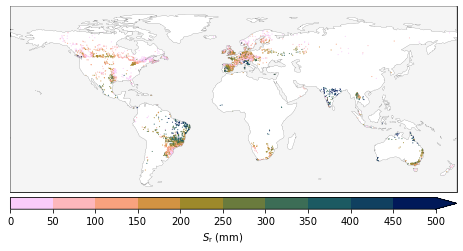

In [5]:
from cmcrameri import cm
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.dropna()
cmap_vd2 = cm.batlow_r

bounds = np.linspace(0,500,11)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,s=0.8,c=df['sr_20'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.012,aspect=38, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$S_\mathrm{r}$ (mm)', size=10)
ax.set_title('',size=14)
fig.savefig(f'{fig_dir}/sr_map_t20.jpg',bbox_inches='tight',dpi=600)

In [6]:
from matplotlib import cm

## 1. CORRELATION MATRIX

In [5]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.drop(columns=['sti','area'])
df = df.drop(columns=['q_mean'])
df = df.dropna()
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')

/tmp/ipykernel_313/3758498390.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')


## 2. PCA

In [6]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.drop(columns=['q_mean'])
df = df.drop(columns=['slp_max','slp_min','slp_std','el_max','el_std','el_min','hand_max','hand_median','hand_min','sti'])
df = df.dropna()
# df.columns

In [7]:
features = df.columns
lf = len(features)
print('length of features:', lf)
X = df[features]
X = X.dropna()
X = StandardScaler().fit_transform(X) #standardize all values
X = pd.DataFrame(X,columns=features)

pca = PCA(n_components=lf)
components = pca.fit_transform(X)

loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])

pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# per_var

length of features: 49


In [8]:
ld_df = pd.DataFrame(index=features, columns=['x-loading','y-loading'])
ld_df['x-loading'] = np.round(loadings[0],2)
ld_df['y-loading'] = np.round(loadings[1],2)
ld_df['length-loading'] = np.round(np.sqrt(loadings[0]**2+loadings[1]**2),2)
# ld_df

In [9]:
ld_sort = abs(ld_df).sort_values('x-loading',ascending=False)
ld_sort = ld_sort[0:25]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['length-loading','y-loading'])
ld_sort['var'] = ld_sort.index
ld_sort.index = ld_sort['rank']
ld_sort = ld_sort.drop(columns='rank')
ld_sort = ld_sort[['var','x-loading']]
# ld_sort

In [10]:
ld_sort = abs(ld_df).sort_values('y-loading',ascending=False)
ld_sort = ld_sort[0:25]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['length-loading','x-loading'])
ld_sort['var'] = ld_sort.index
ld_sort.index = ld_sort['rank']
ld_sort = ld_sort.drop(columns='rank')
ld_sort = ld_sort[['var','y-loading']]
# ld_sort

In [11]:
ld_sort = abs(ld_df).sort_values('length-loading',ascending=False)
ld_sort = ld_sort[0:25]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['x-loading','y-loading'])
ld_sort['var'] = ld_sort.index
ld_sort.index = ld_sort['rank']
ld_sort = ld_sort.drop(columns='rank')
ld_sort = ld_sort[['var','length-loading']]
# ld_sort

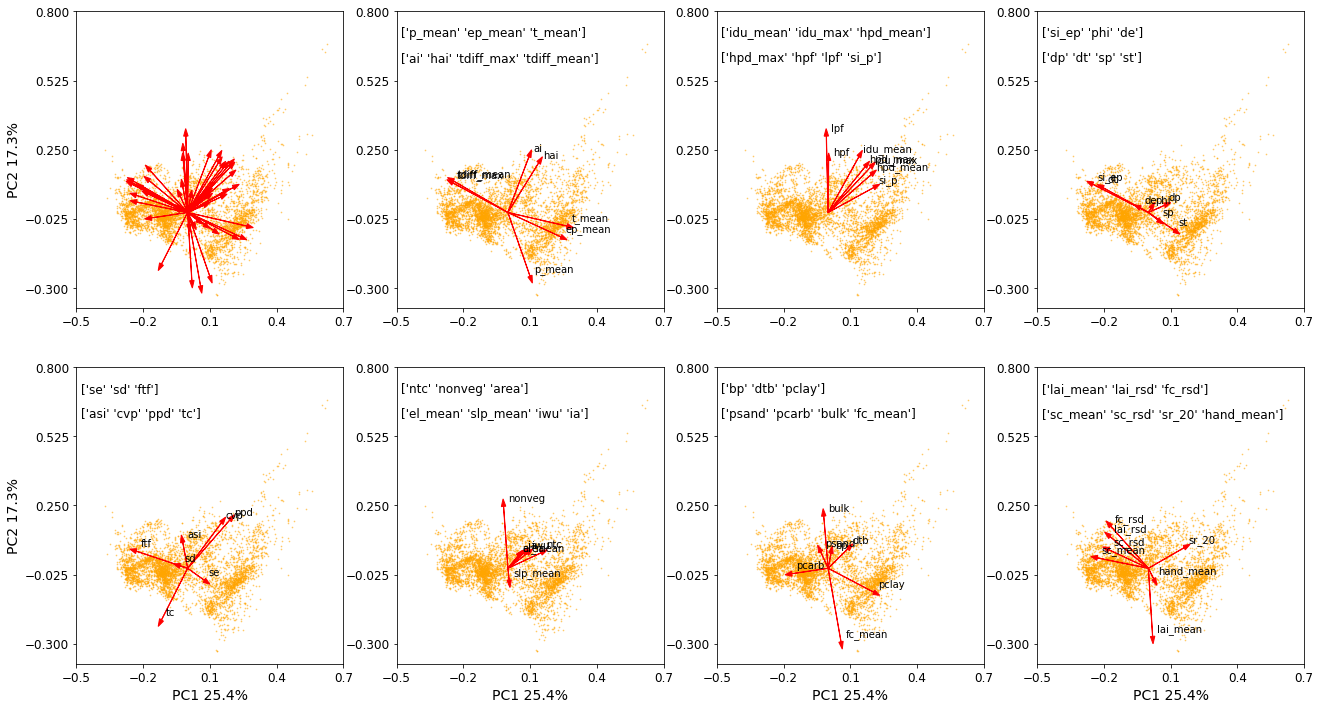

In [12]:
xs = loadings[0]
ys = loadings[1]

ld_df = pd.DataFrame(index=features, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

# split features for visualization of PCA
p = int(np.round((lf/7),0))
features1=features[0:p]
features2=features[p:2*p]
features3=features[2*p:3*p]
features4=features[3*p:4*p]
features5=features[4*p:5*p]
features6=features[5*p:6*p]
features7=features[6*p:]

fig=plt.figure(figsize=(22,12))
ax = fig.add_subplot(241)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')

for i, varnames in enumerate(features):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features[i]]['xs'], # length of the arrow along x
        ld_df.loc[features[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    # ax.text(ld_df.loc[features[i]]['xs']+0.02, ld_df.loc[features[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_xlabel(f'PC1 {per_var[0]}%')
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)

ax = fig.add_subplot(242)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features1):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features1[i]]['xs'], # length of the arrow along x
        ld_df.loc[features1[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features1[i]]['xs']+0.02, ld_df.loc[features1[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features1[0:int(len(features1)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features1[int(len(features1)/2):].values}',size=12)

ax = fig.add_subplot(243)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features2):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features2[i]]['xs'], # length of the arrow along x
        ld_df.loc[features2[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features2[i]]['xs']+0.02, ld_df.loc[features2[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features2[0:int(len(features2)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features2[int(len(features2)/2):].values}',size=12)

ax = fig.add_subplot(244)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features3):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features3[i]]['xs'], # length of the arrow along x
        ld_df.loc[features3[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features3[i]]['xs']+0.02, ld_df.loc[features3[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features3[0:int(len(features3)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features3[int(len(features3)/2):].values}',size=12)

ax = fig.add_subplot(245)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features4):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features4[i]]['xs'], # length of the arrow along x
        ld_df.loc[features4[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features4[i]]['xs']+0.02, ld_df.loc[features4[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
ax.text(-0.48,0.7,f'{features4[0:int(len(features4)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features4[int(len(features4)/2):].values}',size=12)

ax = fig.add_subplot(246)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features5):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features5[i]]['xs'], # length of the arrow along x
        ld_df.loc[features5[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features5[i]]['xs']+0.02, ld_df.loc[features5[i]]['ys']+0.02, varnames,size=10) 
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features5[0:int(len(features5)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features5[int(len(features5)/2):].values}',size=12)

ax = fig.add_subplot(247)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features6):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features6[i]]['xs'], # length of the arrow along x
        ld_df.loc[features6[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features6[i]]['xs']+0.02, ld_df.loc[features6[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features6[0:int(len(features6)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features6[int(len(features6)/2):].values}',size=12)

ax = fig.add_subplot(248)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features7):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features7[i]]['xs'], # length of the arrow along x
        ld_df.loc[features7[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features7[i]]['xs']+0.02, ld_df.loc[features7[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features7[0:int(len(features7)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features7[int(len(features7)/2):].values}',size=12)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters.jpg',bbox_inches='tight',dpi=300)


## 3. RANDOM FOREST

In [6]:
def rf_regression(df,features,n_estimators,max_features,min_samples_leaf,max_depth,random_state,plot,plot2):
    sr_rp = 'sr_20'
    df['catch_id'] = df.index

    ll = ['lat','lon','catch_id']
    f = features + ll
    dfx = df[f].values
    dfy = df[sr_rp].values

    X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.4, random_state=random_state)

    # add removed data in resampling to testset
    # ptx = pt[f].values
    # pty = pt[sr_rp].values
    # X_test = np.concatenate([X_test,ptx])
    # y_test = np.concatenate([y_test,pty.reshape(-1, 1).ravel()])

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',n_estimators=n_estimators, max_features=max_features,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)

    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y_train
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y_train
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

    train_mse = int(mean_squared_error(y_train, train_y_pred))
    train_mae = int(mean_absolute_error(y_train, train_y_pred))
    train_r2 = np.round(r2_score(y_train, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
    train_rmse = int(rmse(y_train,train_y_pred))
    train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

    test_mse = int(mean_squared_error(y_test, test_y_pred))
    test_mae = int(mean_absolute_error(y_test, test_y_pred))
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_rmse = int(rmse(y_test,test_y_pred))
    test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)
    
    n_test = len(y_test)
    n_train = len(y_train)

    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd['pi'] = pi
    dd = dd.sort_values(by='pi')    
    sdf = pd.DataFrame(index=[0])
    sdf[features] = np.round(pi,4)
    # sdf[features] = np.round(rf.feature_importances_,2)
    sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
    sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
    sdf[['n_train','n_test']] = [n_train,n_test]
    
    if (plot==True):
        fig1 = plt.figure(figsize=(17,6))
        ax = fig1.add_subplot(131)
        ax.plot(y_train,train_y_pred,'o',markersize=1)
        ax.plot([0,800],[0,800],'k--')
        ax.set_title(f'Train, r2:{train_r2}, mae={train_mae}mm, n={n_train}')
        ax.set_xlim(-20,800)
        ax.set_ylim(-20,800)
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')

        ax = fig1.add_subplot(132)
        ax.plot(y_test,test_y_pred,'o',markersize=1)
        ax.plot([0,800],[0,800],'k--')
        ax.set_title(f'Test, r2:{test_r2}, mae={test_mae}mm, n={n_test}')
        ax.set_xlim(-20,800)
        ax.set_ylim(-20,800)
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')
        
        ax = fig1.add_subplot(133)
        ax.barh(dd.index,dd.pi)
        ax.set_xlabel('permutation feature importance - decrease in R2')
        
        # cmap_vd2 = cm.get_cmap('RdBu', 21)
        # cmap_rdbu = cm.get_cmap('coolwarm_r', 21)
        # cmap_vd2 = cm.get_cmap('RdBu', 21)
        # cmap_rdbu = cm.get_cmap('coolwarm_r', 21)
        cmap_rdbu = cm.get_cmap('RdYlBu', 20)
        cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3),cmap_rdbu(4),cmap_rdbu(5),cmap_rdbu(6),cmap_rdbu(7),cmap_rdbu(8),
                                    (144/255,238/255,144/255),(144/255,238/255,144/255),
                                   cmap_rdbu(11),cmap_rdbu(12),cmap_rdbu(13),cmap_rdbu(14),cmap_rdbu(15),cmap_rdbu(16),cmap_rdbu(17),cmap_rdbu(18),cmap_rdbu(19)])
        bounds = np.linspace(-100,100,21)
        bounds2 = np.linspace(-100,100,11)
        norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

        train_er = y_train - train_y_pred
        test_er = y_test- test_y_pred
        train_err = (y_train - train_y_pred)/y_train
        test_err = (y_test- test_y_pred)/y_test
        fig2 = plt.figure(figsize=(15,12))
        plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
        ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_train,lat_train,s=1,c=train_er,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('train abs error [sr-mm - sr-pred] (mm)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(train_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()

        ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_test,lat_test,s=1,c=test_er,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('test abs error [sr-mm - sr-pred] (mm)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(test_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()

        bounds = np.linspace(-1,1,21)
        bounds2 = np.linspace(-1,1,11)
        norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

        ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_train,lat_train,s=1,c=train_err,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('train rel error [sr-mm - sr-pred]/sr-mm (-)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(train_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()

        ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_test,lat_test,s=1,c=test_err,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('test rel error [sr-mm - sr-pred]/sr-mm (-)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(test_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()
  
        if (plot2==True):
            fig3, ax = plt.subplots(2,5, figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
            tree_disp = PartialDependenceDisplay.from_estimator(rf, X_train, range(len(features)),feature_names=features,kind='both', ax=ax[0][0:5],
                                                                ice_lines_kw ={'color':'grey'}, line_kw={'color':'orange','linewidth':'3'})
            plt.setp(tree_disp.deciles_vlines_, visible=False)
            ax[0,0].set_ylabel('Sr (mm)')
            ax[0,1].set_ylabel('')
            ax[0,2].set_ylabel('')
            ax[0,3].set_ylabel('')
            ax[0,4].set_ylabel('')
            ax[0,0].set_ylim(0,600)
            ax[0,1].set_ylim(0,600)
            ax[0,2].set_ylim(0,600)
            ax[0,3].set_ylim(0,600)
            ax[0,4].set_ylim(0,600)
            ax[0,0].set_xlim(np.quantile(X_train[:,0],0.05),np.quantile(X_train[:,0],0.95))
            ax[0,1].set_xlim(np.quantile(X_train[:,1],0.05),np.quantile(X_train[:,1],0.95))
            ax[0,2].set_xlim(np.quantile(X_train[:,2],0.05),np.quantile(X_train[:,2],0.95))
            ax[0,3].set_xlim(np.quantile(X_train[:,3],0.05),np.quantile(X_train[:,3],0.95))
            ax[0,4].set_xlim(np.quantile(X_train[:,4],0.05),np.quantile(X_train[:,4],0.95))
            fig3.suptitle('Train',y=0.92,fontsize=16)

            for i in range(len(features)):
                bins = np.linspace(np.quantile(X_train[:,i],0.05),np.quantile(X_train[:,i],0.95),20)
                ax[1,i].hist(X_train[:,i],bins=bins)
                ax[1,i].invert_yaxis()
                ax[1,i].xaxis.tick_top()
                ax[1,i].set_xlim(np.quantile(X_train[:,i],0.05),np.quantile(X_train[:,i],0.95))
                ax[1,i].axes.get_xaxis().set_ticklabels([])
            ax[1,0].set_ylabel('#catchments')
            
            fig4, ax = plt.subplots(2,5, figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
            tree_disp = PartialDependenceDisplay.from_estimator(rf, X_test, range(len(features)),feature_names=features,kind='both', ax=ax[0][0:5],
                                                                ice_lines_kw ={'color':'grey'}, line_kw={'color':'orange','linewidth':'3'})
            plt.setp(tree_disp.deciles_vlines_, visible=False)
            ax[0,0].set_ylabel('Sr (mm)')
            ax[0,1].set_ylabel('')
            ax[0,2].set_ylabel('')
            ax[0,3].set_ylabel('')
            ax[0,4].set_ylabel('')
            ax[0,0].set_ylim(0,600)
            ax[0,1].set_ylim(0,600)
            ax[0,2].set_ylim(0,600)
            ax[0,3].set_ylim(0,600)
            ax[0,4].set_ylim(0,600)
            ax[0,0].set_xlim(np.quantile(X_test[:,0],0.05),np.quantile(X_test[:,0],0.95))
            ax[0,1].set_xlim(np.quantile(X_test[:,1],0.05),np.quantile(X_test[:,1],0.95))
            ax[0,2].set_xlim(np.quantile(X_test[:,2],0.05),np.quantile(X_test[:,2],0.95))
            ax[0,3].set_xlim(np.quantile(X_test[:,3],0.05),np.quantile(X_test[:,3],0.95))
            ax[0,4].set_xlim(np.quantile(X_test[:,4],0.05),np.quantile(X_test[:,4],0.95))
            fig4.suptitle('Test',y=0.92,fontsize=16)

            for i in range(len(features)):
                bins = np.linspace(np.quantile(X_test[:,i],0.05),np.quantile(X_test[:,i],0.95),20)
                ax[1,i].hist(X_test[:,i],bins=bins)
                ax[1,i].invert_yaxis()
                ax[1,i].xaxis.tick_top()
                ax[1,i].set_xlim(np.quantile(X_test[:,i],0.05),np.quantile(X_test[:,i],0.95))
                ax[1,i].axes.get_xaxis().set_ticklabels([])
            ax[1,0].set_ylabel('#catchments')
            
            return sdf,df_train,df_test,fig1,fig2,fig3,fig4
        else:
            return sdf,df_train,df_test,fig1,fig2
    else:
        return sdf,df_train,df_test

### Hyperparameter tuning

## sequential feature selection

In [ ]:
min_samples_leaf=1
max_depth=16
n_estimators=100
max_features=0.5
random_states=[12,22,32,38,41]
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df.dropna()
df = df[df.p_mean-df.q_mean < df.ep_mean]
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
f = features 
dfx = df[f].values
dfy = df[sr_rp].values

X, X_test, y, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.4,random_state=21)
estimator=RandomForestRegressor(criterion='absolute_error',random_state=42)
sfs = SequentialFeatureSelector(estimator, n_features_to_select=4,direction="forward")
sfs.fit(X, y)

In [ ]:
sfs.get_support()

In [ ]:
sfs.transform(X).shape

In [ ]:
df = pd.DataFrame(index=f,columns=['rank'])
df['rank'] = sfs.ranking_
df.sort_values('rank')

## manual feature elimination using permutation feature importance

In [7]:
# ALL CATCHMENTS ALL VARIABLES
min_samples_leaf=1
max_depth=None
n_estimators=100
max_features=1
random_states=[12,22,32,38,41,13,23,33,39,42]
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df.dropna()
df = df[df.p_mean-df.q_mean < df.ep_mean]
pp = []
for k in range(len(random_states)):
    random_state = random_states[k]
    features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean','lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
    ll = []
    for i in range(len(features)):
        sdf = rf_regression(df,features,n_estimators,max_features,min_samples_leaf,max_depth,random_state,plot=False,plot2=False)[0]
        sdff = sdf[features]
        minx = sdff.values.argmin()
        dr = features[minx]
        ll.append(dr)
        features.remove(dr)
        # print(len(features))
    ll.reverse()
    # d  = pd.DataFrame(index=range(len(ll)),columns=['rank','features'])
    # d.loc[:,'features'] = ll
    # d.loc[:,'rank'] = np.arange(0,22,1)
    d  = pd.DataFrame(index=ll,columns=['rank'])
    d.loc[:,'rank'] = np.arange(0,len(ll),1)
    pp.append(d)

In [8]:
d = pd.concat(pp,axis=1)
dm = pd.DataFrame(d.mean(axis=1))
dm = dm.sort_values(by=0)
dm

0
idu_mean     0.1
sc_mean      1.2
t_mean       1.9
p_mean       3.1
lpf          4.2
si_p         5.0
tdiff_mean   6.2
ep_mean      7.8
slp_mean     8.6
asi          8.7
pclay        9.8
si_ep       10.1
ntc         12.3
dtb         13.3
lai_rsd     14.4
lai_mean    16.4
tc          16.6
el_mean     17.0
sc_rsd      17.3
nonveg      17.5
psand       18.7
ia          20.8

### spatial resampling

3194


Text(0.5, 0, 'Sr (mm)')

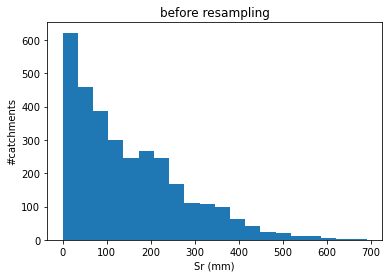

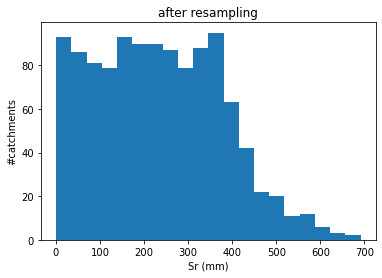

In [23]:
# sample equally for each sr bin
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df.dropna()
df = df[df.p_mean-df.q_mean < df.ep_mean]
print(len(df))
dfs = df.sort_values(by='sr_20')
gr = np.arange(0,950,50)
gr = [  0,  50, 100, 150, 200, 250, 300, 350, 400]#, 900]
gr2 = [  0,  50, 100, 150, 200, 250, 300, 350, 400]#, 900]
l=[]
p=[]
for i in range(len(gr)-1):
    s = dfs[(dfs.sr_20>gr[i])&(dfs.sr_20<gr[i+1])]
    # print(len(s))
    ix = random.sample(np.arange(0,len(s)).tolist(),125)
    p.append(s.iloc[ix])
    l.append(len(s))
#sr larger than 400: use all
s = dfs[(dfs.sr_20>400)]
p.append(s)
pp = pd.concat(p)

plt.figure()
plt.hist(dfs.sr_20,bins=20)
plt.title('before resampling')
plt.ylabel('#catchments')
plt.xlabel('Sr (mm)')

plt.figure()
plt.hist(pp.sr_20,bins=20)
plt.title('after resampling')
plt.ylabel('#catchments')
plt.xlabel('Sr (mm)')

## Crossvalidation model to test robustness

## Manual feature elimination with cross validation

In [75]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
# features = ['t_mean','p_mean','idu_mean','asi']
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
f = features 
dfx = df[f].values
dfy = df[sr_rp].values
cv_outer = 4 # the number of outer cross validations
l = []
pp = []
kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
i=0
for train_ix, test_ix in kf.split(dfx):
    features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
    f = features
    ll = []
    for i in range(len(f)):
        dfx = df[features].values
        dfy = df[sr_rp].values
        X = dfx[train_ix]
        y = dfy[train_ix]
        X_test = dfx[test_ix]
        y_test = dfy[test_ix]
        
        rf = RandomForestRegressor(criterion='absolute_error',random_state=42)
        rf.fit(X,y)
        test_y_pred = rf.predict(X_test)
        train_y_pred = rf.predict(X)
        n_train,n_test = len(y),len(y_test)

        train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
        train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)

        test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
        test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
        
        perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
        # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
        pi = perm_importance.importances_mean
        dd = pd.DataFrame(index=features,columns=['pi'])
        dd['pi'] = pi
        dd = dd.sort_values(by='pi')    
        sdf = pd.DataFrame(index=[0])
        sdf[features] = np.round(pi,4)
    
        sdff = sdf[features]
        minx = sdff.values.argmin()
        dr = features[minx]
        ll.append(dr)
        features.remove(dr)   
    
    ll.reverse()
    d  = pd.DataFrame(index=ll,columns=['rank'])
    d.loc[:,'rank'] = np.arange(0,len(ll),1)
    pp.append(d)    


In [76]:
d = pd.concat(pp,axis=1)
dm = pd.DataFrame(d.mean(axis=1))
ds = d.std(axis=1)
dm = dm.sort_values(by=0)
dm['mean'] = dm[0]
dm['std'] = ds
dm = dm.drop(columns=0)
dm

mean       std
idu_mean     0.00  0.000000
t_mean       1.00  0.000000
tdiff_mean   2.25  0.500000
p_mean       2.75  0.500000
sc_mean      4.00  0.000000
asi          5.00  0.000000
ep_mean      6.50  0.577350
slp_mean     6.50  0.577350
si_p         8.25  0.500000
pclay        8.75  0.500000
ntc         11.50  1.290994
lai_mean    12.00  2.160247
dtb         12.50  3.785939
lai_rsd     13.50  1.914854
nonveg      13.50  1.290994
si_ep       14.00  2.449490
el_mean     15.75  1.258306
psand       16.00  2.160247
sc_rsd      17.50  1.290994
tc          18.75  0.500000
ia          20.00  0.000000

# MODEL A

In [5]:
mod = 'modela'

In [6]:
#Europe
lat_min_e, lat_max_e = 35,72 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,29 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 8,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 22,62
lon_min_u, lon_max_u = -132,-55

#south america
lat_min_s, lat_max_s = -32,-4
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -36,-17
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

### cross validation

In [152]:
max_depth=None
min_samples_leaf=10

In [153]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
df['catch_id'] = df.index
# features = ['t_mean','p_mean','idu_mean','asi']
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 4 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)

    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj']] = [train_mae,train_r2_adj]
    sdf.loc[i][['test_mae','test_r2_adj']] = [test_mae,test_r2_adj]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)

    i+=1

# sdf.to_csv(f'{work_dir}/cross_validation/output/sdf_kinner{cv_inner}_kouter{cv_outer}_var{len(features)}_v2.csv')

0
1
2
3


In [154]:
sdf

n_estimators max_depth min_samples_leaf max_features train_mae train_r2_adj  \
0          NaN       NaN              NaN          NaN     34.01         0.82   
1          NaN       NaN              NaN          NaN     34.07         0.82   
2          NaN       NaN              NaN          NaN     33.86         0.83   
3          NaN       NaN              NaN          NaN      34.1         0.83   

  test_mae test_r2_adj n_train n_test fold  
0    40.14        0.78    2395    799    0  
1     41.3        0.76    2395    799    1  
2    42.05        0.74    2396    798    2  
3    42.43        0.74    2396    798    3

In [155]:
mae_train_mean = (sdf.train_mae.mean(axis=0))
mae_train_std = (sdf.train_mae.std(axis=0))
mae_test_mean = (sdf.test_mae.mean(axis=0))
mae_test_std = (sdf.test_mae.std(axis=0))
print(mae_train_mean, mae_train_std)
print(mae_test_mean, mae_test_std)

34.01 0.10677078252031383
41.48 1.0091910952176824


In [156]:
# permutation importances for each cv fold
ddd = pd.DataFrame(index=ddl[0].index, columns=['pi0','pi1','pi2','pi3'])
ddd.pi0 = ddl[0].pi
ddd.pi1 = ddl[1].pi
ddd.pi2 = ddl[2].pi
ddd.pi3 = ddl[3].pi
ddd['mean'] = ddd.mean(axis=1)
ddd['std'] = ddd[['pi0','pi1','pi2','pi3']].std(axis=1)
ddd = ddd.sort_values(by='mean',ascending=False)
ddd['features2'] = ['$I_{\mathrm{ISD}}$','$I_{\mathrm{d,T}}$','$\overline{T}$', '$I_{\mathrm{AS}}$','$\overline{P}$','$I_{\mathrm{S,P}}$','$\overline{E}_\mathrm{p}$',
                    '$\overline{f}_{\mathrm{snow}}$','$f_{\mathrm{clay}}$','$s$','$\overline{\mathrm{LAI}}$','$f_{\mathrm{nontree}}$','$d_{\mathrm{b}}$','$I_{\mathrm{S,E_p}}$','$LAI_\mathrm{v}$',
                    '$f_{\mathrm{nonveg}}$','$e$','$f_{\mathrm{sand}}$','$f_{\mathrm{snow,v}}$','$f_{\mathrm{tree}}$','$I_\mathrm{a}$']
rb = cm.get_cmap('tab10', 9)
c1,c2,c3,c4,c5,c6,c7,c8,c9 = rb(0),rb(1),rb(2),rb(3),rb(4),rb(5),rb(6),rb(7),rb(8)
ddd['colors'] = [c1,c2,c2,c8,c4,c4,c2,c2,c6,c3,c9,c9,c5,c2,c9,c9,c3,c6,c2,c9,c7]
ddd

pi0        pi1        pi2        pi3       mean       std  \
idu_mean    24.852137  23.795208  24.155270  26.730220  24.883209  1.307167   
tdiff_mean  12.958341  14.526123   8.303637  16.872452  13.165138  3.618168   
t_mean       8.086612   7.614242   9.540422   5.755047   7.749081  1.561749   
asi          3.806913   3.964489   4.396247   4.823085   4.247683  0.457397   
p_mean       4.362128   3.298669   3.981464   3.347718   3.747495  0.514387   
si_p         4.778937   3.220051   3.204027   2.639243   3.460564  0.919481   
pclay        2.226638   3.390789   3.422741   3.819701   3.214967  0.687164   
ep_mean      2.808131   3.496149   3.133659   1.857750   2.823922  0.702748   
sc_mean      3.046690   2.780222   2.286131   2.638985   2.688007  0.316788   
slp_mean     2.103626   2.196145   1.760038   2.838521   2.224582  0.450245   
si_ep        0.986351   1.053437   1.167529   0.901559   1.027219  0.112302   
lai_mean     0.986906   1.203872   0.789027   0.815120   0.948731  0.191408   
ntc          0.791236   0.814226   0.844764   1.161111   0.902834  0.173575   
el_mean      1.196897   0.888984   0.357229   1.067310   0.877605  0.369168   
dtb          1.047412   0.404058   1.198310   0.390248   0.760007  0.423530   
lai_rsd      0.805368   0.691997   0.602711   0.836471   0.734137  0.107385   
psand        0.754355   0.410701   0.627436   0.741752   0.633561  0.159165   
nonveg       0.507692   0.606395   0.558893   0.627874   0.575214  0.053451   
sc_rsd       0.593322   0.329021   0.406367   0.521512   0.462556  0.117706   
tc           0.556594   0.213125   0.252702   0.283259   0.326420  0.156112   
ia           0.181836   0.282905   0.188753   0.239117   0.223153  0.047314   

                                 features2  \
idu_mean                $I_{\mathrm{ISD}}$   
tdiff_mean              $I_{\mathrm{d,T}}$   
t_mean                      $\overline{T}$   
asi                      $I_{\mathrm{AS}}$   
p_mean                      $\overline{P}$   
si_p                    $I_{\mathrm{S,P}}$   
pclay            $\overline{E}_\mathrm{p}$   
ep_mean     $\overline{f}_{\mathrm{snow}}$   
sc_mean                $f_{\mathrm{clay}}$   
slp_mean                               $s$   
si_ep            $\overline{\mathrm{LAI}}$   
lai_mean            $f_{\mathrm{nontree}}$   
ntc                       $d_{\mathrm{b}}$   
el_mean               $I_{\mathrm{S,E_p}}$   
dtb                       $LAI_\mathrm{v}$   
lai_rsd              $f_{\mathrm{nonveg}}$   
psand                                  $e$   
nonveg                 $f_{\mathrm{sand}}$   
sc_rsd               $f_{\mathrm{snow,v}}$   
tc                     $f_{\mathrm{tree}}$   
ia                          $I_\mathrm{a}$   

                                                       colors  
idu_mean    (0.12156862745098039, 0.4666666666666667, 0.70...  
tdiff_mean  (1.0, 0.4980392156862745, 0.054901960784313725...  
t_mean      (1.0, 0.4980392156862745, 0.054901960784313725...  
asi         (0.7372549019607844, 0.7411764705882353, 0.133...  
p_mean      (0.8392156862745098, 0.15294117647058825, 0.15...  
si_p        (0.8392156862745098, 0.15294117647058825, 0.15...  
pclay       (1.0, 0.4980392156862745, 0.054901960784313725...  
ep_mean     (1.0, 0.4980392156862745, 0.054901960784313725...  
sc_mean     (0.8901960784313725, 0.4666666666666667, 0.760...  
slp_mean    (0.17254901960784313, 0.6274509803921569, 0.17...  
si_ep       (0.09019607843137255, 0.7450980392156863, 0.81...  
lai_mean    (0.09019607843137255, 0.7450980392156863, 0.81...  
ntc         (0.5490196078431373, 0.33725490196078434, 0.29...  
el_mean     (1.0, 0.4980392156862745, 0.054901960784313725...  
dtb         (0.09019607843137255, 0.7450980392156863, 0.81...  
lai_rsd     (0.09019607843137255, 0.7450980392156863, 0.81...  
psand       (0.17254901960784313, 0.6274509803921569, 0.17...  
nonveg      (0.8901960784313725, 0.4666666666666667, 0.760...  
sc_rsd      (1.0, 0.4980392156862745, 0.0549019607

In [157]:
# get mae for different regions
ll_e = lat_max_e, lat_min_e, lon_max_e, lon_min_e
ll_a = lat_max_a, lat_min_a, lon_max_a, lon_min_a
ll_u = lat_max_u, lat_min_u, lon_max_u, lon_min_u
ll_s = lat_max_s, lat_min_s, lon_max_s, lon_min_s
ll_f = lat_max_f, lat_min_f, lon_max_f, lon_min_f
ll_t = lat_max_t, lat_min_t, lon_max_t, lon_min_t
ll = [ll_e,ll_a,ll_u,ll_s,ll_f,ll_t]

dfr = pd.DataFrame(index=[0,1,2,3], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrr = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrr.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrr.loc['std',:] = np.round(dfr.std(axis=0),2)

dfr = pd.DataFrame(index=[0,1,2,3], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrrt = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrrt.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrrt.loc['std',:] = np.round(dfr.std(axis=0),2)

In [158]:
#train
dfrr

mad_europe mad_asia mad_northamerica mad_southamerica mad_southafrica  \
mean       29.0     76.0             25.0             34.0            40.0   
std         0.9     3.82             0.42             0.78             0.7   

     mad_australia  
mean          39.0  
std           3.06

In [159]:
#test
dfrrt

mad_europe mad_asia mad_northamerica mad_southamerica mad_southafrica  \
mean       36.0     92.0             30.0             41.0            47.0   
std        1.65     11.6             2.74             2.29            4.67   

     mad_australia  
mean          44.0  
std          11.77

In [160]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
# features = ['t_mean','p_mean','idu_mean','asi']
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']

In [161]:
df

p_mean   ep_mean    q_mean     t_mean        ai       hai  \
ca_0002351  1.590253  1.401269  0.455940   0.643260  0.881161  0.419085   
cz_0000019  2.285853  1.484881  0.972639   7.528472  0.649596  0.593821   
br_0001191  4.152597  3.260944  1.209388  24.602384  0.785278  0.956434   
br_0000469  4.944120  3.258352  1.958321  26.827793  0.659036  0.875518   
bw_0000006  1.358820  2.669859  0.077338  20.623299  1.964836  2.449571   
...              ...       ...       ...        ...       ...       ...   
in_0000089  3.441414  2.745652  0.979561  25.608996  0.797827  1.172824   
br_0000128  5.936997  4.090981  2.370459  27.015993  0.689066  0.734160   
ca_0000419  2.655707  1.932424  1.425366   4.734362  0.727650  0.457049   
in_0000016  2.526809  2.758476  0.915937  26.032707  1.091684  1.628218   
es_0000295  3.104931  1.965884  1.158912  10.646137  0.633149  0.555933   

            tdiff_max  tdiff_mean  idu_mean  idu_max  ...  lai_mean   lai_rsd  \
ca_0002351  32.852726   25.221876      5.05    22.43  ...  0.950806  0.641162   
cz_0000019  28.280451   22.165638      3.81    20.90  ...  1.885474  0.753561   
br_0001191   5.747533    4.562576      2.67    12.20  ...  2.808409  0.113255   
br_0000469   3.563315    2.495693      6.62    43.07  ...  1.862262  0.252759   
bw_0000006  12.241637   10.890681     12.46   131.85  ...  0.581395  0.657466   
...               ...         ...       ...      ...  ...       ...       ...   
in_0000089  17.002852   14.829664     16.92    68.04  ...  0.903943  0.637682   
br_0000128   3.681301    2.138738      4.50    23.93  ...  5.570754  0.016118   
ca_0000419  34.849674   31.055583      3.20    15.85  ...  2.142158  0.828244   
in_0000016  16.066249   14.215958     22.23   122.46  ...  0.678283  0.707684   
es_0000295  18.534686   16.186555      4.04    23.55  ...  1.257364  0.524027   

              fc_rsd    sc_mean    sc_rsd       sr_20     hand_max  \
ca_0002351  0.572026  41.416667  0.833385   86.685585  1501.171875   
cz_0000019  0.597933  25.416667  1.311083   51.682482   939.671875   
br_0001191  0.052783   0.000000  0.000000  173.824040   522.171875   
br_0000469  0.175812   0.000000  0.000000  333.062414   217.156250   
bw_0000006  0.548385   0.000000  0.000000  221.777925  1271.609375   
...              ...        ...       ...         ...          ...   
in_0000089  0.562167   0.000000  0.000000  579.886473   720.734375   
br_0000128  0.008920   0.000000  0.000000  417.746791   243.781250   
ca_0000419  0.602794  35.750000  1.228926   72.704485    94.609375   
in_0000016  0.660581   0.000000  0.000000  373.351268   388.796875   
es_0000295  0.421732  12.333333  1.258638  189.217162  1795.546875   

             hand_mean  hand_median  hand_min  
ca_0002351  161.245301    76.216726  1.984375  
cz_0000019  120.060104    85.911332  1.015625  
br_0001191   60.038479    41.895014  5.281250  
br_0000469   30.572604    24.476506  1.171875  
bw_0000006   24.544601    19.774955  2.156250  
...                ...          ...       ...  
in_0000089   33.167393    22.004360  0.000000  
br_0000128   23.816584    21.490157  2.140625  
ca_0000419   28.260328    25.263614  0.000000  
in_0000016   25.614706    20.983718  1.359375  
es_0000295  172.522666   108.005634  0.000000  

[3194 rows x 84 columns]

In [162]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[0]
test_ix = cv_test_ix[0]

# X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)
X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
# rf = RandomForestRegressor(criterion='squared_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth,oob_score=True)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
# sdf[features] = np.round(rf.feature_importances_,2)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


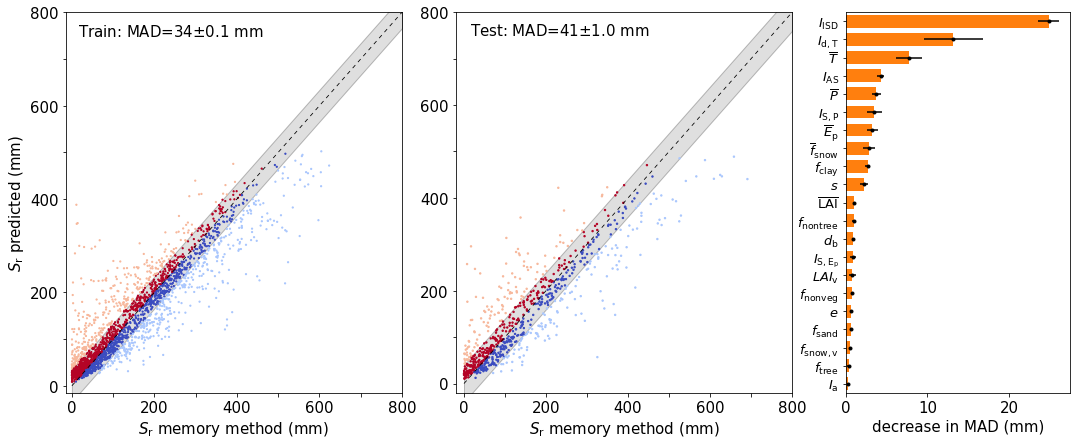

In [163]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(1),cmap_rdbu(0),cmap_rdbu(3),cmap_rdbu(2)])
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,3, figsize=(18,7),gridspec_kw={'width_ratios': [3,3,2]})
plt.subplots_adjust(wspace=0.18)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c=df_train.group,s=1.5,cmap=cmap_rdbu,norm=norm,zorder=10)
# ax.plot(y_train,train_y_pred,'o',color='tab:blue',markersize=0.8)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].fill_between(x, y-train_mae, y+train_mae, alpha=0.25, edgecolor='k', facecolor='grey')
# ax.set_title(f'Train, MAD={train_mae} mm, $n$={n_train}',size=15)
# ax[0].text(15,750,f'MAD={train_mae} mm ',fontsize=15)#mad of this specific run
ax[0].text(15,750,f'Train: MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm',fontsize=15)#mad mean and std of cv
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=15)
ax[0].set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=15)
ax[0].tick_params(axis='both', labelsize=15)
# fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_train.jpg',bbox_inches='tight',dpi=300)


# fig1 = plt.figure(figsize=(6,6))
# ax = fig1.add_subplot(132)
# ax.plot(y_test,test_y_pred,'o',color='tab:orange',markersize=1)
s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c=df_test.group,s=2,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].fill_between(x, y-test_mae, y+test_mae, alpha=0.25, edgecolor='k', facecolor='grey')
# ax.set_title(f'Test, MAD={test_mae} mm, $n$={n_test}',size=15)
# ax[1].text(15,750,f'MAD={test_mae} mm',fontsize=15)#mad of this specific run
ax[1].text(15,750,f'Test: MAD={int(mae_test_mean)}$\pm${np.round(mae_test_std,1)} mm',fontsize=15)#mad mean and std of cv
ax[1].set_xlim(-20,800)
ax[1].set_ylim(-20,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=15)
# ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=15)
ax[1].tick_params(axis='both', labelsize=15)

# feature importances
# ax = fig1.add_subplot(133)
ddd = ddd.sort_values(by='mean')
# ax[2].barh(ddd.features2,ddd['mean'],height=0.7,color=ddd.colors)
ax[2].barh(ddd.features2,ddd['mean'],height=0.7,color='tab:orange')
ax[2].errorbar(ddd['mean'],ddd.features2, xerr=ddd['std'], fmt=".", color="black")
# ax.set_title('Train permutation feature importance',size=14)
ax[2].set_xlabel('decrease in MAD (mm)',size=15)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=13)
ax[2].set_ylim(-0.5,20.5)
# for i in range(len(ddd.features2)):
#     ax.text(ddd['mean'][i]+1,i-0.5,ddd.features2[i],fontsize=13)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)


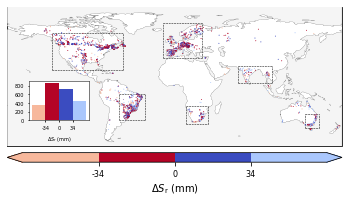

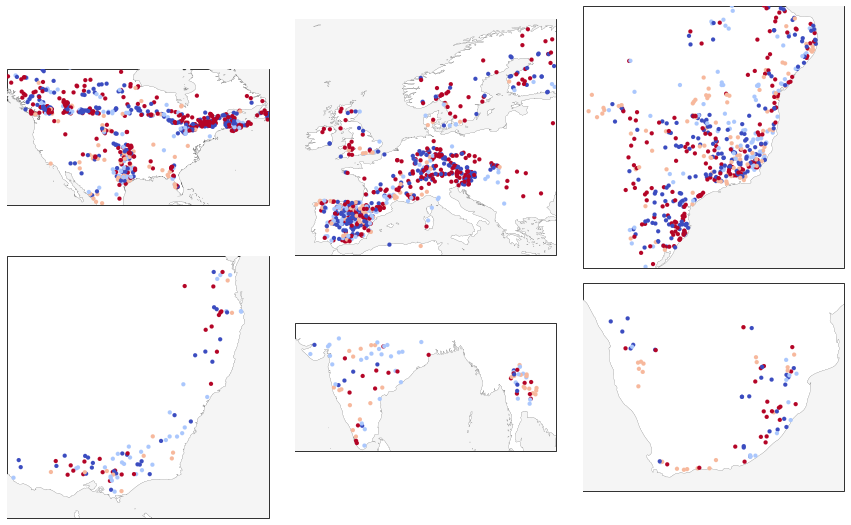

In [164]:
# TRAIN
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_train,lat_train,s=0.7,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=35, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{train_mae}','0',f'{train_mae}'],size=8)
# for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
#     cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')
# for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
#     cbar.ax.text(0.5,(j + 0.5), lab, ha='center', va='center',rotation=90,size=6)
ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_t,lon_max_t],[lat_max_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_max_t],[lat_min_t,lat_min_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_min_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_t,lon_max_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_f,lon_max_f],[lat_max_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_max_f],[lat_min_f,lat_min_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_min_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_f,lon_max_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.05,0.15,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins = [df_train['Sr_p-Sr_m'].quantile(0.01),-train_mae,0,train_mae,df_train['Sr_p-Sr_m'].quantile(0.99)]
n = [len(df_train[df_train.group==0]['Sr_p-Sr_m']),len(df_train[df_train.group==1]['Sr_p-Sr_m']),len(df_train[df_train.group==2]['Sr_p-Sr_m']),len(df_train[df_train.group==3]['Sr_p-Sr_m'])]
iax.bar([0,1,2,3],n,width=1,color=[cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
iax.set_xticks([0.5,1.5,2.5])
iax.set_yticks([0,200,400,600,800])
iax.set_xticklabels([f'-{train_mae}','0',f'{train_mae}'])
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=5)
# iax.invert_yaxis()
# iax.yaxis.tick_right()
# iax.set_ylabel('$n$',size=6)
# iax.yaxis.set_label_position("right")
# iax.xaxis.tick_top()
iax.tick_params(axis='both',length=1.5, labelsize=5)

# ax.set_title('train abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/train_maps_{mod}.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.15)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_u,lat_max_u)
ax.set_xlim(lon_min_u,lon_max_u)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_e,lat_max_e)
ax.set_xlim(lon_min_e,lon_max_e)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_s,lat_max_s)
ax.set_xlim(lon_min_s,lon_max_s)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_t,lat_max_t)
ax.set_xlim(lon_min_t,lon_max_t)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_a,lat_max_a)
ax.set_xlim(lon_min_a,lon_max_a)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_f,lat_max_f)
ax.set_xlim(lon_min_f,lon_max_f)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/train_maps_zoomed_{mod}.jpg',bbox_inches='tight',dpi=300)

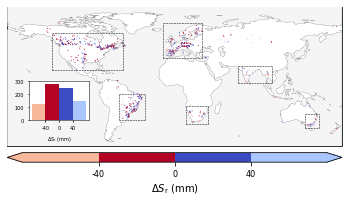

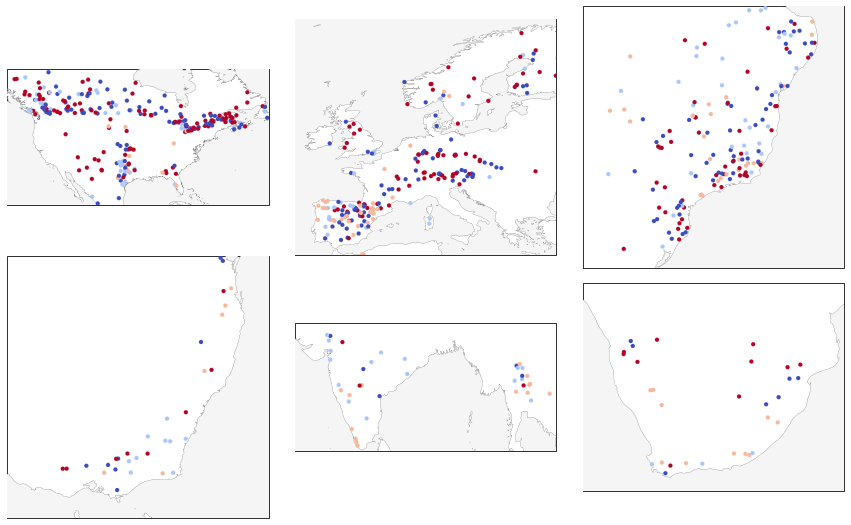

In [165]:
# TEST
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_test,lat_test,s=0.7,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=35, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{test_mae}','0',f'{test_mae}'],size=8)
# for j, lab in enumerate([f'$n$={len(df_test[df_test.group==0])}',f'$n$={len(df_test[df_test.group==1])}',f'$n$={len(df_test[df_test.group==2])}',f'$n$={len(df_test[df_test.group==3])}']):
#     cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')
# for j, lab in enumerate([f'$n$={len(df_test[df_test.group==0])}',f'$n$={len(df_test[df_test.group==1])}',f'$n$={len(df_test[df_test.group==2])}',f'$n$={len(df_test[df_test.group==3])}']):
#     cbar.ax.text(0.5,(j + 0.5), lab, ha='center', va='center',rotation=90,size=6)
ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_t,lon_max_t],[lat_max_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_max_t],[lat_min_t,lat_min_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_min_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_t,lon_max_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_f,lon_max_f],[lat_max_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_max_f],[lat_min_f,lat_min_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_min_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_f,lon_max_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.05,0.15,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins = [df_test['Sr_p-Sr_m'].quantile(0.01),-test_mae,0,test_mae,df_test['Sr_p-Sr_m'].quantile(0.99)]
n = [len(df_test[df_test.group==0]['Sr_p-Sr_m']),len(df_test[df_test.group==1]['Sr_p-Sr_m']),len(df_test[df_test.group==2]['Sr_p-Sr_m']),len(df_test[df_test.group==3]['Sr_p-Sr_m'])]
iax.bar([0,1,2,3],n,width=1,color=[cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
iax.set_xticks([0.5,1.5,2.5])
iax.set_yticks([0,100,200,300])
iax.set_xticklabels([f'-{test_mae}','0',f'{test_mae}'])
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=5)
# iax.invert_yaxis()
# iax.yaxis.tick_right()
# iax.set_ylabel('$n$',size=6)
# iax.yaxis.set_label_position("right")
# iax.xaxis.tick_top()
iax.tick_params(axis='both',length=1.5, labelsize=5)

# ax.set_title('test abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/test_maps_{mod}.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.15)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_u,lat_max_u)
ax.set_xlim(lon_min_u,lon_max_u)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_e,lat_max_e)
ax.set_xlim(lon_min_e,lon_max_e)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_s,lat_max_s)
ax.set_xlim(lon_min_s,lon_max_s)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_t,lat_max_t)
ax.set_xlim(lon_min_t,lon_max_t)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_a,lat_max_a)
ax.set_xlim(lon_min_a,lon_max_a)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_f,lat_max_f)
ax.set_xlim(lon_min_f,lon_max_f)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/test_maps_zoomed_{mod}.jpg',bbox_inches='tight',dpi=300)


# MODEL B

In [76]:
mod = 'modelb'

In [77]:
min_samples_leaf=10
max_depth=None
# n_estimators=100
# max_features=1

### cross validation

In [78]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
df['catch_id'] = df.index
features = ['idu_mean','t_mean','asi','p_mean']
# features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 3 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)

    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    # perm_importance = permutation_importance(rf, X_train, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj']] = [train_mae,train_r2_adj]
    sdf.loc[i][['test_mae','test_r2_adj']] = [test_mae,test_r2_adj]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)

    i+=1

# sdf.to_csv(f'{work_dir}/cross_validation/output/sdf_kinner{cv_inner}_kouter{cv_outer}_var{len(features)}_v2.csv')

0
1
2


In [79]:
sdf

n_estimators max_depth min_samples_leaf max_features train_mae train_r2_adj  \
0          NaN       NaN              NaN          NaN     38.26         0.78   
1          NaN       NaN              NaN          NaN     38.81         0.78   
2          NaN       NaN              NaN          NaN     38.43         0.78   

  test_mae test_r2_adj n_train n_test fold  
0    46.44        0.72    2129   1065    0  
1     45.9         0.7    2129   1065    1  
2     46.8         0.7    2130   1064    2

In [80]:
mae_train_mean = (sdf.train_mae.mean(axis=0))
mae_train_std = (sdf.train_mae.std(axis=0))
mae_test_mean = (sdf.test_mae.mean(axis=0))
mae_test_std = (sdf.test_mae.std(axis=0))
print(mae_train_mean, mae_train_std)
print(mae_test_mean, mae_test_std)

38.5 0.2816025568065766
46.379999999999995 0.45299006611624426


In [81]:
# # permutation importances for each cv fold
# ddd = pd.DataFrame(index=ddl[0].index, columns=['pi0','pi1','pi2','pi3'])
# ddd.pi0 = ddl[0].pi
# ddd.pi1 = ddl[1].pi
# ddd.pi2 = ddl[2].pi
# ddd.pi3 = ddl[3].pi
# ddd['mean'] = ddd.mean(axis=1)
# ddd['std'] = ddd[['pi0','pi1','pi2','pi3']].std(axis=1)
# ddd = ddd.sort_values(by='mean',ascending=False)
# # ddd['features2'] = ['$I_{\mathrm{ISD}}$','$I_{\mathrm{d,T}}$','$\overline{T}$', '$I_{\mathrm{AS}}$','$\overline{P}$','$I_{\mathrm{S,P}}$','$\overline{E}_\mathrm{p}$',
#                     # '$\overline{f}_{\mathrm{snow}}$','$f_{\mathrm{clay}}$','$s$','$\overline{\mathrm{LAI}}$','$f_{\mathrm{nontree}}$','$d_{\mathrm{b}}$','$I_{\mathrm{S,E_p}}$','$LAI_\mathrm{v}$',
#                     # '$f_{\mathrm{nonveg}}$','$e$','$f_{\mathrm{sand}}$','$f_{\mathrm{snow,v}}$','$f_{\mathrm{tree}}$','$I_\mathrm{a}$']
# # rb = cm.get_cmap('tab10', 9)
# # c1,c2,c3,c4,c5,c6,c7,c8,c9 = rb(0),rb(1),rb(2),rb(3),rb(4),rb(5),rb(6),rb(7),rb(8)
# # ddd['colors'] = [c1,c2,c2,c8,c4,c4,c2,c2,c6,c3,c9,c9,c5,c2,c9,c9,c3,c6,c2,c9,c7]
# ddd

In [82]:
# get mae for different regions
ll_e = lat_max_e, lat_min_e, lon_max_e, lon_min_e
ll_a = lat_max_a, lat_min_a, lon_max_a, lon_min_a
ll_u = lat_max_u, lat_min_u, lon_max_u, lon_min_u
ll_s = lat_max_s, lat_min_s, lon_max_s, lon_min_s
ll_f = lat_max_f, lat_min_f, lon_max_f, lon_min_f
ll_t = lat_max_t, lat_min_t, lon_max_t, lon_min_t
ll = [ll_e,ll_a,ll_u,ll_s,ll_f,ll_t]

dfr = pd.DataFrame(index=[0,1,2,3], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = train_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrr = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrr.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrr.loc['std',:] = np.round(dfr.std(axis=0),2)

dfr = pd.DataFrame(index=[0,1,2,3], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
for i in range(len(train_dfs)):
    df = test_dfs[i]
    for j in range(len(ll)):
        k = ll[j]
        lat_max,lat_min,lon_max,lon_min = k[0],k[1],k[2],k[3]
        dfs = df[(df.lat<lat_max)&(df.lat>lat_min)&(df.lon<lon_max)&(df.lon>lon_min)]
        mae = abs(dfs['Sr_p-Sr_m']).mean()
        dfr.iloc[i,j] = mae
dfrrt = pd.DataFrame(index=['mean','std'], columns=['mad_europe','mad_asia','mad_northamerica','mad_southamerica','mad_southafrica','mad_australia'])
dfrrt.loc['mean',:] = np.round(dfr.mean(axis=0),0)
dfrrt.loc['std',:] = np.round(dfr.std(axis=0),2)

In [83]:
#train
dfrr

mad_europe mad_asia mad_northamerica mad_southamerica mad_southafrica  \
mean       32.0     87.0             30.0             36.0            45.0   
std        0.92     2.64             0.39              0.7            1.64   

     mad_australia  
mean          49.0  
std           4.61

In [84]:
#test
dfrrt

mad_europe mad_asia mad_northamerica mad_southamerica mad_southafrica  \
mean       40.0    100.0             36.0             44.0            53.0   
std        2.15     9.85             1.83             1.96            0.97   

     mad_australia  
mean          58.0  
std          11.17

In [87]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
features = ['idu_mean','t_mean','asi','p_mean']
# features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']


In [88]:
df

p_mean   ep_mean    q_mean     t_mean        ai       hai  \
ca_0002351  1.590253  1.401269  0.455940   0.643260  0.881161  0.419085   
cz_0000019  2.285853  1.484881  0.972639   7.528472  0.649596  0.593821   
br_0001191  4.152597  3.260944  1.209388  24.602384  0.785278  0.956434   
br_0000469  4.944120  3.258352  1.958321  26.827793  0.659036  0.875518   
bw_0000006  1.358820  2.669859  0.077338  20.623299  1.964836  2.449571   
...              ...       ...       ...        ...       ...       ...   
in_0000089  3.441414  2.745652  0.979561  25.608996  0.797827  1.172824   
br_0000128  5.936997  4.090981  2.370459  27.015993  0.689066  0.734160   
ca_0000419  2.655707  1.932424  1.425366   4.734362  0.727650  0.457049   
in_0000016  2.526809  2.758476  0.915937  26.032707  1.091684  1.628218   
es_0000295  3.104931  1.965884  1.158912  10.646137  0.633149  0.555933   

            tdiff_max  tdiff_mean  idu_mean  idu_max  ...  lai_mean   lai_rsd  \
ca_0002351  32.852726   25.221876      5.05    22.43  ...  0.950806  0.641162   
cz_0000019  28.280451   22.165638      3.81    20.90  ...  1.885474  0.753561   
br_0001191   5.747533    4.562576      2.67    12.20  ...  2.808409  0.113255   
br_0000469   3.563315    2.495693      6.62    43.07  ...  1.862262  0.252759   
bw_0000006  12.241637   10.890681     12.46   131.85  ...  0.581395  0.657466   
...               ...         ...       ...      ...  ...       ...       ...   
in_0000089  17.002852   14.829664     16.92    68.04  ...  0.903943  0.637682   
br_0000128   3.681301    2.138738      4.50    23.93  ...  5.570754  0.016118   
ca_0000419  34.849674   31.055583      3.20    15.85  ...  2.142158  0.828244   
in_0000016  16.066249   14.215958     22.23   122.46  ...  0.678283  0.707684   
es_0000295  18.534686   16.186555      4.04    23.55  ...  1.257364  0.524027   

              fc_rsd    sc_mean    sc_rsd       sr_20     hand_max  \
ca_0002351  0.572026  41.416667  0.833385   86.685585  1501.171875   
cz_0000019  0.597933  25.416667  1.311083   51.682482   939.671875   
br_0001191  0.052783   0.000000  0.000000  173.824040   522.171875   
br_0000469  0.175812   0.000000  0.000000  333.062414   217.156250   
bw_0000006  0.548385   0.000000  0.000000  221.777925  1271.609375   
...              ...        ...       ...         ...          ...   
in_0000089  0.562167   0.000000  0.000000  579.886473   720.734375   
br_0000128  0.008920   0.000000  0.000000  417.746791   243.781250   
ca_0000419  0.602794  35.750000  1.228926   72.704485    94.609375   
in_0000016  0.660581   0.000000  0.000000  373.351268   388.796875   
es_0000295  0.421732  12.333333  1.258638  189.217162  1795.546875   

             hand_mean  hand_median  hand_min  
ca_0002351  161.245301    76.216726  1.984375  
cz_0000019  120.060104    85.911332  1.015625  
br_0001191   60.038479    41.895014  5.281250  
br_0000469   30.572604    24.476506  1.171875  
bw_0000006   24.544601    19.774955  2.156250  
...                ...          ...       ...  
in_0000089   33.167393    22.004360  0.000000  
br_0000128   23.816584    21.490157  2.140625  
ca_0000419   28.260328    25.263614  0.000000  
in_0000016   25.614706    20.983718  1.359375  
es_0000295  172.522666   108.005634  0.000000  

[3194 rows x 84 columns]

In [89]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[1]
test_ix = cv_test_ix[1]

# X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)
X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
# rf = RandomForestRegressor(criterion='squared_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth,oob_score=True)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
# sdf[features] = np.round(rf.feature_importances_,2)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


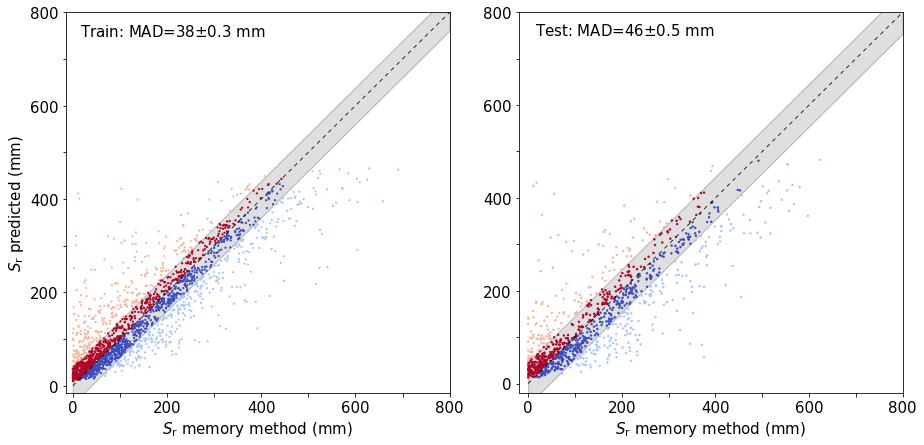

In [90]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(1),cmap_rdbu(0),cmap_rdbu(3),cmap_rdbu(2)])
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1, ax = plt.subplots(1,2, figsize=(15,7),gridspec_kw={'width_ratios': [1,1]})
plt.subplots_adjust(wspace=0.18)
s=ax[0].scatter(df_train.Sr_m,df_train.Sr_p,c=df_train.group,s=1.5,cmap=cmap_rdbu,norm=norm,zorder=10)
# ax.plot(y_train,train_y_pred,'o',color='tab:blue',markersize=0.8)
ax[0].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[0].fill_between(x, y-train_mae, y+train_mae, alpha=0.25, edgecolor='k', facecolor='grey')
# ax.set_title(f'Train, MAD={train_mae} mm, $n$={n_train}',size=15)
# ax[0].text(15,750,f'MAD={train_mae} mm ',fontsize=15)#mad of this specific run
ax[0].text(15,750,f'Train: MAD={int(mae_train_mean)}$\pm${np.round(mae_train_std,1)} mm',fontsize=15)#mad mean and std of cv
ax[0].set_xlim(-15,800)
ax[0].set_ylim(-15,800)
ax[0].set_yticks([0,100,200,300,400,500,600,700,800])
ax[0].set_xticks([0,100,200,300,400,500,600,700,800])
ax[0].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[0].set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=15)
ax[0].set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=15)
ax[0].tick_params(axis='both', labelsize=15)
# fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_train.jpg',bbox_inches='tight',dpi=300)


# fig1 = plt.figure(figsize=(6,6))
# ax = fig1.add_subplot(132)
# ax.plot(y_test,test_y_pred,'o',color='tab:orange',markersize=1)
s=ax[1].scatter(df_test.Sr_m,df_test.Sr_p,c=df_test.group,s=2,cmap=cmap_rdbu,norm=norm,zorder=10)
ax[1].plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
ax[1].fill_between(x, y-test_mae, y+test_mae, alpha=0.25, edgecolor='k', facecolor='grey')
# ax.set_title(f'Test, MAD={test_mae} mm, $n$={n_test}',size=15)
# ax[1].text(15,750,f'MAD={test_mae} mm',fontsize=15)#mad of this specific run
ax[1].text(15,750,f'Test: MAD={int(mae_test_mean)}$\pm${np.round(mae_test_std,1)} mm',fontsize=15)#mad mean and std of cv
ax[1].set_xlim(-20,800)
ax[1].set_ylim(-20,800)
ax[1].set_yticks([0,100,200,300,400,500,600,700,800])
ax[1].set_xticks([0,100,200,300,400,500,600,700,800])
ax[1].set_yticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xticklabels([0,'',200,'',400,'',600,'',800])
ax[1].set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=15)
# ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=15)
ax[1].tick_params(axis='both', labelsize=15)

fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_{mod}.jpg',bbox_inches='tight',dpi=300)


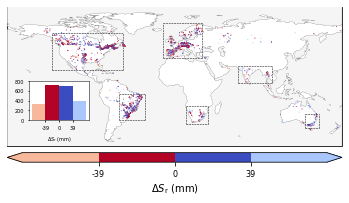

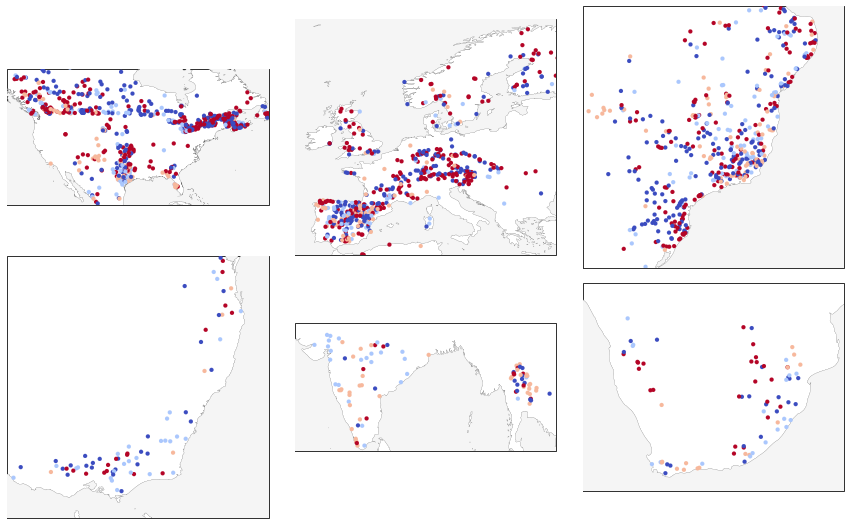

In [91]:
# TRAIN
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_train,lat_train,s=0.7,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=35, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{train_mae}','0',f'{train_mae}'],size=8)
# for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
#     cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')
# for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
#     cbar.ax.text(0.5,(j + 0.5), lab, ha='center', va='center',rotation=90,size=6)
ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_t,lon_max_t],[lat_max_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_max_t],[lat_min_t,lat_min_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_min_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_t,lon_max_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_f,lon_max_f],[lat_max_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_max_f],[lat_min_f,lat_min_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_min_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_f,lon_max_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.05,0.15,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins = [df_train['Sr_p-Sr_m'].quantile(0.01),-train_mae,0,train_mae,df_train['Sr_p-Sr_m'].quantile(0.99)]
n = [len(df_train[df_train.group==0]['Sr_p-Sr_m']),len(df_train[df_train.group==1]['Sr_p-Sr_m']),len(df_train[df_train.group==2]['Sr_p-Sr_m']),len(df_train[df_train.group==3]['Sr_p-Sr_m'])]
iax.bar([0,1,2,3],n,width=1,color=[cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
iax.set_xticks([0.5,1.5,2.5])
iax.set_yticks([0,200,400,600,800])
iax.set_xticklabels([f'-{train_mae}','0',f'{train_mae}'])
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=5)
# iax.invert_yaxis()
# iax.yaxis.tick_right()
# iax.set_ylabel('$n$',size=6)
# iax.yaxis.set_label_position("right")
# iax.xaxis.tick_top()
iax.tick_params(axis='both',length=1.5, labelsize=5)

# ax.set_title('train abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/train_maps_{mod}.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.15)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_u,lat_max_u)
ax.set_xlim(lon_min_u,lon_max_u)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_e,lat_max_e)
ax.set_xlim(lon_min_e,lon_max_e)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_s,lat_max_s)
ax.set_xlim(lon_min_s,lon_max_s)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_t,lat_max_t)
ax.set_xlim(lon_min_t,lon_max_t)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_a,lat_max_a)
ax.set_xlim(lon_min_a,lon_max_a)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_f,lat_max_f)
ax.set_xlim(lon_min_f,lon_max_f)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/train_maps_zoomed_{mod}.jpg',bbox_inches='tight',dpi=300)

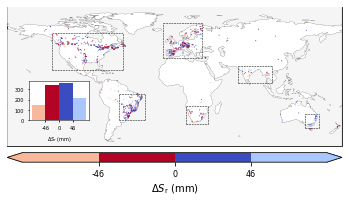

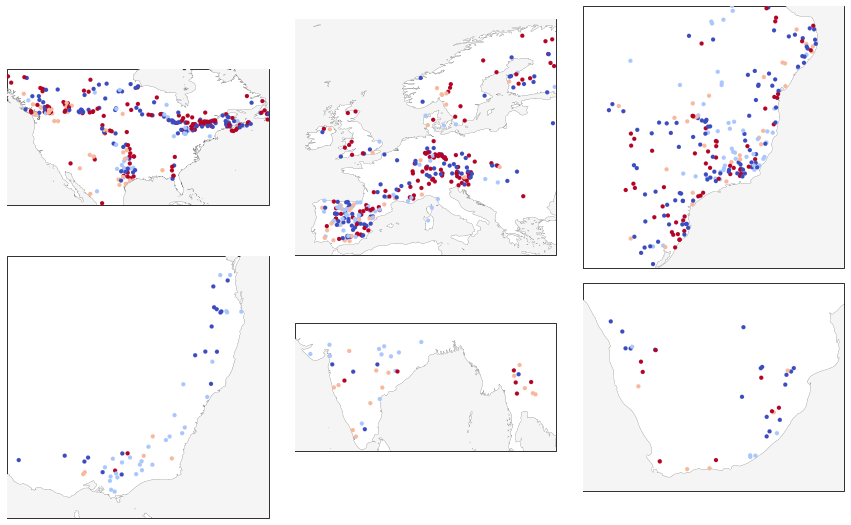

In [92]:
# TEST
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_test,lat_test,s=0.7,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=35, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{test_mae}','0',f'{test_mae}'],size=8)
# for j, lab in enumerate([f'$n$={len(df_test[df_test.group==0])}',f'$n$={len(df_test[df_test.group==1])}',f'$n$={len(df_test[df_test.group==2])}',f'$n$={len(df_test[df_test.group==3])}']):
#     cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')
# for j, lab in enumerate([f'$n$={len(df_test[df_test.group==0])}',f'$n$={len(df_test[df_test.group==1])}',f'$n$={len(df_test[df_test.group==2])}',f'$n$={len(df_test[df_test.group==3])}']):
#     cbar.ax.text(0.5,(j + 0.5), lab, ha='center', va='center',rotation=90,size=6)
ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_t,lon_max_t],[lat_max_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_max_t],[lat_min_t,lat_min_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_min_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_t,lon_max_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_f,lon_max_f],[lat_max_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_max_f],[lat_min_f,lat_min_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_min_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_f,lon_max_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.05,0.15,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins = [df_test['Sr_p-Sr_m'].quantile(0.01),-test_mae,0,test_mae,df_test['Sr_p-Sr_m'].quantile(0.99)]
n = [len(df_test[df_test.group==0]['Sr_p-Sr_m']),len(df_test[df_test.group==1]['Sr_p-Sr_m']),len(df_test[df_test.group==2]['Sr_p-Sr_m']),len(df_test[df_test.group==3]['Sr_p-Sr_m'])]
iax.bar([0,1,2,3],n,width=1,color=[cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
iax.set_xticks([0.5,1.5,2.5])
iax.set_yticks([0,100,200,300])
iax.set_xticklabels([f'-{test_mae}','0',f'{test_mae}'])
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=5)
# iax.invert_yaxis()
# iax.yaxis.tick_right()
# iax.set_ylabel('$n$',size=6)
# iax.yaxis.set_label_position("right")
# iax.xaxis.tick_top()
iax.tick_params(axis='both',length=1.5, labelsize=5)

# ax.set_title('test abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/test_maps_{mod}.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.15)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_u,lat_max_u)
ax.set_xlim(lon_min_u,lon_max_u)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_e,lat_max_e)
ax.set_xlim(lon_min_e,lon_max_e)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_s,lat_max_s)
ax.set_xlim(lon_min_s,lon_max_s)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_t,lat_max_t)
ax.set_xlim(lon_min_t,lon_max_t)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_a,lat_max_a)
ax.set_xlim(lon_min_a,lon_max_a)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_f,lat_max_f)
ax.set_xlim(lon_min_f,lon_max_f)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/test_maps_zoomed_{mod}.jpg',bbox_inches='tight',dpi=300)


## PDP plots

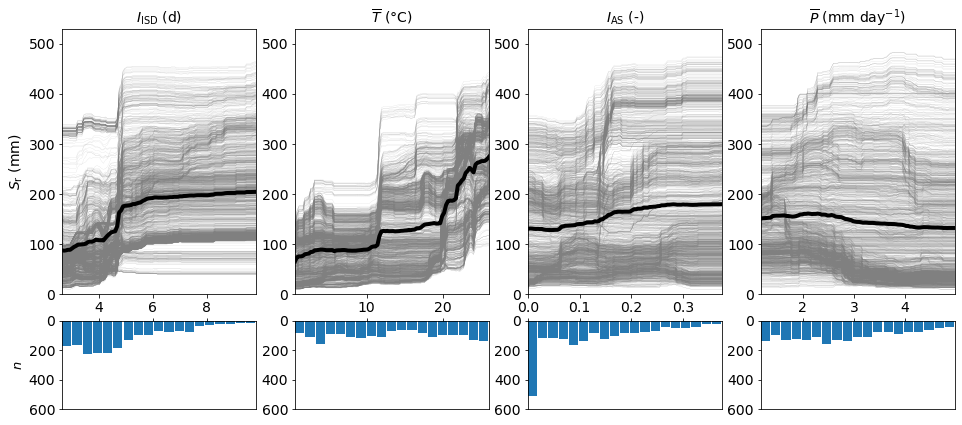

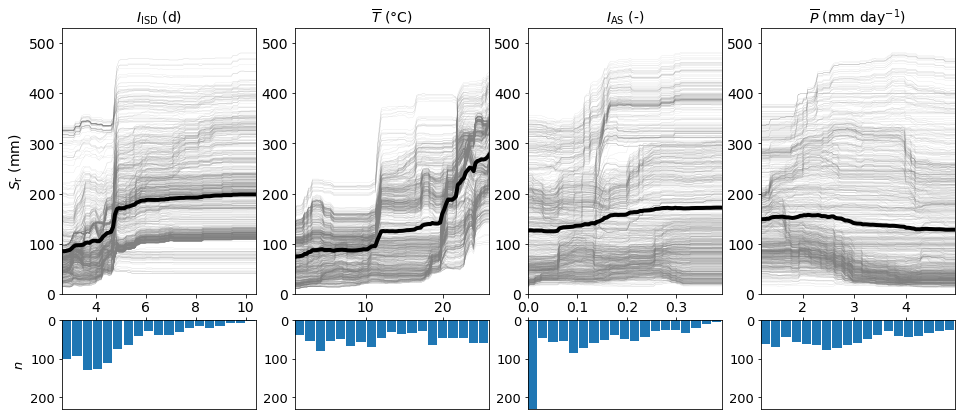

In [ ]:
var = ['$I_\mathrm{ISD}$','$\overline{T}$','$I_\mathrm{AS}$','$\overline{P}$']
units = ['d','$\degree$C','-','mm $\mathrm{day}^{-1}$']
abcd = ['(a)','(b)','(c)','(d)']

# plot pdp TRAIN
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X_train, percentiles=(0.05, 0.95), grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=df_train.index, data = a['individual'][0],columns=a['values'][0])
    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.07)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{var[k]} ({units[k]})',size=14)
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X_train[:,k],0.05),np.quantile(X_train[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=14)
       
    bins = np.linspace(np.quantile(X_train[:,k],0.05),np.quantile(X_train[:,k],0.95),20)
    ax[1,k].hist(X_train[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X_train[:,k],0.05),np.quantile(X_train[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=13)
    ax[1,k].tick_params(axis='both', labelsize=14)
    ax[1,k].set_ylim(600,0)
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{mod}.jpg',bbox_inches='tight',dpi=300)

    
# plot pdp TEST
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X_test, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=df_test.index, data = a['individual'][0],columns=a['values'][0])

    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.07)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{var[k]} ({units[k]})',size=14)
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X_test[:,k],0.05),np.quantile(X_test[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=14)
       
    bins = np.linspace(np.quantile(X_test[:,k],0.05),np.quantile(X_test[:,k],0.95),20)
    ax[1,k].hist(X_test[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X_test[:,k],0.05),np.quantile(X_test[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=13)
    ax[1,k].tick_params(axis='both', labelsize=13)
    ax[1,k].set_ylim(230,0)
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_test_{mod}.jpg',bbox_inches='tight',dpi=300)


# plot pdp TRAIN+TEST
X = np.concatenate([X_train,X_test])
ddf = pd.concat([df_train,df_test])
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.05)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{abcd[k]} {var[k]} ({units[k]})',size=15)
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=14)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,k].hist(X[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=13)
    ax[1,k].tick_params(axis='both', labelsize=13)
    ax[1,k].set_ylim(800,0)
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_traintest_{mod}.jpg',bbox_inches='tight',dpi=300)

In [ ]:
abcd = ['(a)','(b)','(c)','(d)']

# plot pdp TRAIN+TEST
X = np.concatenate([X_train,X_test])
ddf = pd.concat([df_train,df_test])
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15,wspace=0.08)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.05)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{abcd[k]} {var[k]} ({units[k]})',size=15, loc='left')
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=15)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=15)
    ax[0,k].set_yticks([0,100,200,300,400,500])
    ax[0,k].set_yticklabels(['','','','','',''])
    ax[0,0].set_yticklabels(['0','100','200','300','400','500'])
           
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,k].hist(X[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=15)
    ax[1,k].tick_params(axis='both', labelsize=15)
    ax[1,k].set_ylim(800,0)
    ax[1,k].set_yticks([0,250,500,750])
    ax[1,k].set_yticklabels(['','','',''])
    ax[1,0].set_yticklabels(['0','','500',''])
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_traintest_{mod}.jpg',bbox_inches='tight',dpi=300)

## MAKE MANUAL SPLITS

In [ ]:
c1 = '#FF1F5B'
c2 = '#009ADE'
c3 = '#AF58BA'
c4 = '#FFC61E'

In [ ]:
# get ices
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)

# t_mean
k = 0 
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp_t = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice_t = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# p_mean
k = 1 
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp_p = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice_p = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# idu_mean
k = 2
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp_idu = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice_idu = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# asi
k = 3 
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp_asi = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice_asi = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

In [ ]:
# make groups
# tmean
pos = []
neg = []
slp = (ice_t.iloc[:,-1] - ice_t.iloc[:,0])/(ice_t.columns[-1] - ice_t.columns[0])
for i in ice_t.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)
pm = slp.loc[pos].mean()
t1 = slp[slp>pm].index
t2 = slp[(slp<=pm) & (slp>0)].index
t1=[]
t2=[]
for i in pos:
    if (((ice_t.loc[i].iloc[50] - ice_t.loc[i].iloc[0])/(ice_t.columns[50] - ice_t.columns[0]) > 5)|((ice_t.loc[i].iloc[15] - ice_t.loc[i].iloc[0])/(ice_t.columns[15] - ice_t.columns[0]) > 10)):
        t1.append(i)
    else:
        t2.append(i)
        
# idumean
pos = []
neg = []
slp = (ice_idu.iloc[:,-1] - ice_idu.iloc[:,0])/(ice_idu.columns[-1] - ice_idu.columns[0])
for i in ice_idu.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
i1 = slp[slp>0.9*pm].index
i2 = slp[(slp<=0.9*pm) & (slp>0)].index

# asi
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
a1 = slp[slp>1.1*pm].index
a2 = slp[(slp<=1.1*pm) & (slp>0)].index

In [ ]:
# make plots
var = ['idu_mean','t_mean','asi']
# var = ['$\overline{T}$','$\overline{P}$','$I_\mathrm{ISD}$','$I_\mathrm{AS}$']
abcd = ['(a)','(b)','(c)','(d)']
fig, ax = plt.subplots(6,2, figsize=(10,21),gridspec_kw={'height_ratios': [3, 1, 3, 1,3,1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
# plot pdps
cmap_rdbu = cm.get_cmap('PuOr_r', 4)

for m in range(len(var)):
    if (var[m]=='t_mean'):
        gr1 = t1
        gr2 = t2
        ice = ice_t
    if (var[m]=='idu_mean'):
        gr1 = i1
        gr2 = i2
        ice = ice_idu
    if (var[m]=='asi'):
        gr1 = a1
        gr2 = a2
        ice = ice_asi
    mm = m*2
    if (len(gr1)>0):
        gr = gr1
        j = 0
        for i in gr:
            ax[mm,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
        ax[mm,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
        ax[mm,j].set_title(f'{var[m]} ({units[m]}), $n$={len(gr)}',size=14)
        ax[mm,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
        ax[mm,j].set_ylim(0,550)
        ax[mm,j].set_xlim(np.quantile(X[:,m],0.05),np.quantile(X[:,m],0.95))
        ax[mm,j].tick_params(axis='both', labelsize=13)

        bins = np.linspace(np.quantile(X[:,m],0.05),np.quantile(X[:,m],0.95),20)
        ax[mm+1,j].hist(df.loc[gr,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]))
        ax[mm+1,j].invert_yaxis()
        ax[mm+1,j].xaxis.tick_top()
        ax[mm+1,j].set_xlim(np.quantile(X[:,m],0.05),np.quantile(X[:,m],0.95))
        ax[mm+1,j].axes.get_xaxis().set_ticklabels([])
        ax[mm+1,j].set_ylabel('$n$',size=13)
        ax[mm+1,j].tick_params(axis='both', labelsize=13)
        ax[mm+1,j].set_ylim(220,0)

    if (len(gr2)>0):
        gr = gr2
        j = 1
        for i in gr:
            ax[mm,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
        ax[mm,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
        ax[mm,j].set_title(f'{var[m]} ({units[m]}), $n$={len(gr)}',size=14)
        # ax[0,j].set_ylabel('Sr (mm)',size=13)
        ax[mm,j].set_ylim(0,550)
        ax[mm,j].set_xlim(np.quantile(X[:,m],0.05),np.quantile(X[:,m],0.95))
        ax[mm,j].tick_params(axis='both', labelsize=13)

        bins = np.linspace(np.quantile(X[:,m],0.05),np.quantile(X[:,m],0.95),20)
        ax[mm+1,j].hist(df.loc[gr,features[m]],bins=bins,width=0.9*(bins[1]-bins[0]))
        ax[mm+1,j].invert_yaxis()
        ax[mm+1,j].xaxis.tick_top()
        ax[mm+1,j].set_xlim(np.quantile(X[:,m],0.05),np.quantile(X[:,m],0.95))
        ax[mm+1,j].axes.get_xaxis().set_ticklabels([])
        # ax[1,j].set_ylabel('$n$',size=13)
        ax[mm+1,j].tick_params(axis='both', labelsize=13)
        ax[mm+1,j].set_ylim(220,0)
    

In [ ]:
# idu_mean
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)

# t_mean
fig, ax = plt.subplots(2,2, figsize=(10,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 0 # 't_mean'
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
gr1 = slp[slp>pm].index
gr2 = slp[(slp<=pm) & (slp>0)].index
gr1=[]
gr2=[]
for i in pos:
    if (((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 5)|((ice.loc[i].iloc[15] - ice.loc[i].iloc[0])/(ice.columns[15] - ice.columns[0]) > 10)): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0])): # 
        gr1.append(i)
    else:
        gr2.append(i)

# plot pdps
cmap_rdbu = cm.get_cmap('PuOr_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(220,0)
    
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(220,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)


In [ ]:
ice.iloc[:,0:15]

In [ ]:
cmap = ListedColormap([c1,c2])

features = ['t_mean','p_mean','idu_mean','asi']
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
ff = features
ff.append('sr_20')
df = df[ff]
df = df.loc[ice.index]
df.loc[gr1,'gr'] = 0
df.loc[gr2,'gr'] = 1
# df.loc[gr3,'gr'] = 2
# df.loc[gr4,'gr'] = 3

xx = df[features]
xx = StandardScaler().fit_transform(xx) #standardize all values
xx = pd.DataFrame(xx,columns=ff)
pca = PCA(n_components=len(ff))
components = pca.fit_transform(xx)
loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
pca_df_scaled = pca_df.copy()
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]
per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

xs = loadings[0]
ys = loadings[1]
ld_df = pd.DataFrame(index=ff, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

fig=plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,c=df.gr,cmap=cmap)
for i, varnames in enumerate(ff):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[ff[i]]['xs'], # length of the arrow along x
        ld_df.loc[ff[i]]['ys'], # length of the arrow along y
        color='grey',
        head_width=0.02
        )
    ax.text(ld_df.loc[ff[i]]['xs']+0.02, ld_df.loc[ff[i]]['ys']+0.02, varnames,size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pca_t_mean_splitted.jpg',bbox_inches='tight',dpi=300)


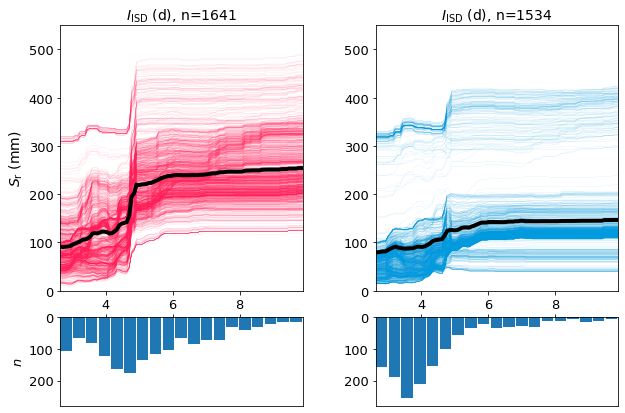

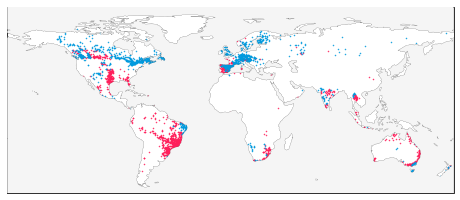

In [97]:
# idu_mean
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)

fig, ax = plt.subplots(2,2, figsize=(10,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 2 # 'idu_mean'
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
gr1 = slp[slp>0.9*pm].index
gr2 = slp[(slp<=0.9*pm) & (slp>0)].index
# gr1=[]
# gr2=[]
# for i in pos:
#     if ((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 4): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0])): # 
#         gr1.append(i)
#     else:
#         gr2.append(i)

# plot pdps
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    ax[0,j].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(280,0)
    
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(280,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)

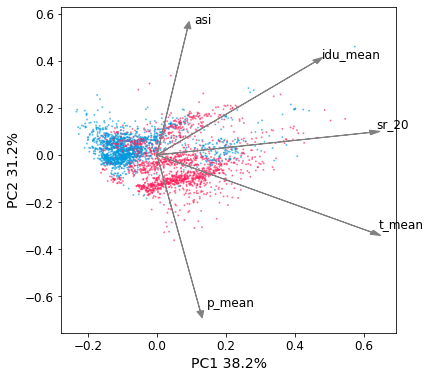

In [81]:
cmap = ListedColormap([c1,c2])

features = ['t_mean','p_mean','idu_mean','asi']
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
ff = features
ff.append('sr_20')
df = df[ff]
df = df.loc[ice.index]
df.loc[gr1,'gr'] = 0
df.loc[gr2,'gr'] = 1
# df.loc[gr3,'gr'] = 2
# df.loc[gr4,'gr'] = 3

xx = df[features]
xx = StandardScaler().fit_transform(xx) #standardize all values
xx = pd.DataFrame(xx,columns=ff)
pca = PCA(n_components=len(ff))
components = pca.fit_transform(xx)
loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
pca_df_scaled = pca_df.copy()
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]
per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

xs = loadings[0]
ys = loadings[1]
ld_df = pd.DataFrame(index=ff, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

fig=plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,c=df.gr,cmap=cmap)
for i, varnames in enumerate(ff):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[ff[i]]['xs'], # length of the arrow along x
        ld_df.loc[ff[i]]['ys'], # length of the arrow along y
        color='grey',
        head_width=0.02
        )
    ax.text(ld_df.loc[ff[i]]['xs']+0.02, ld_df.loc[ff[i]]['ys']+0.02, varnames,size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pca_idu_mean_splitted.jpg',bbox_inches='tight',dpi=300)

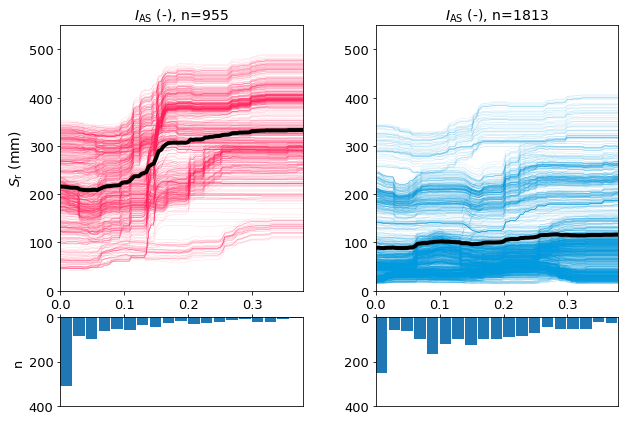

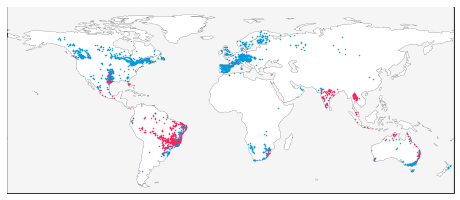

In [100]:
# asi
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)

fig, ax = plt.subplots(2,2, figsize=(10,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 3 # asi
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
gr1 = slp[slp>1.1*pm].index
gr2 = slp[(slp<=1.1*pm) & (slp>0)].index

# plot pdps
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.07)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    ax[0,j].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(400,0)
    
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.07)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(400,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)

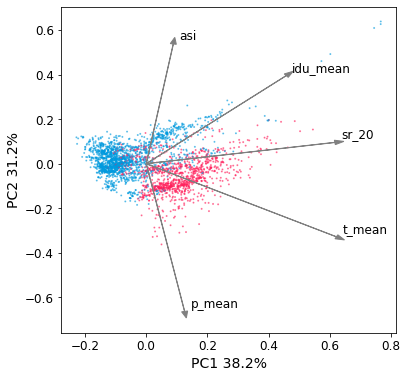

In [83]:
cmap = ListedColormap([c1,c2])

features = ['t_mean','p_mean','idu_mean','asi']
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
ff = features
ff.append('sr_20')
df = df[ff]
df = df.loc[ice.index]
df.loc[gr1,'gr'] = 0
df.loc[gr2,'gr'] = 1
# df.loc[gr3,'gr'] = 2
# df.loc[gr4,'gr'] = 3

xx = df[features]
xx = StandardScaler().fit_transform(xx) #standardize all values
xx = pd.DataFrame(xx,columns=ff)
pca = PCA(n_components=len(ff))
components = pca.fit_transform(xx)
loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
pca_df_scaled = pca_df.copy()
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]
per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

xs = loadings[0]
ys = loadings[1]
ld_df = pd.DataFrame(index=ff, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

fig=plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,c=df.gr,cmap=cmap)
for i, varnames in enumerate(ff):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[ff[i]]['xs'], # length of the arrow along x
        ld_df.loc[ff[i]]['ys'], # length of the arrow along y
        color='grey',
        head_width=0.02
        )
    ax.text(ld_df.loc[ff[i]]['xs']+0.02, ld_df.loc[ff[i]]['ys']+0.02, varnames,size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pca_asi_mean_splitted.jpg',bbox_inches='tight',dpi=300)

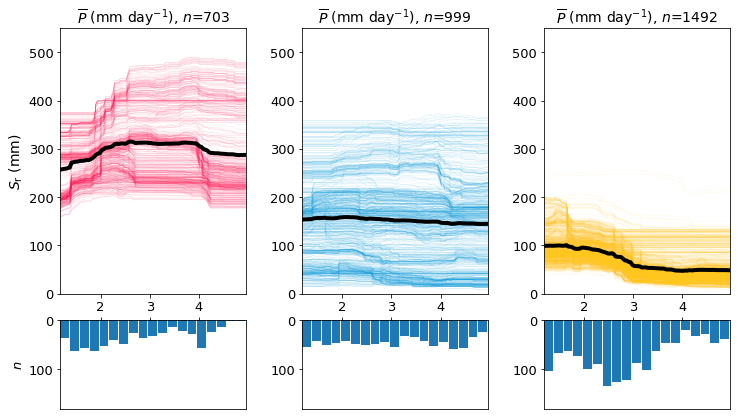

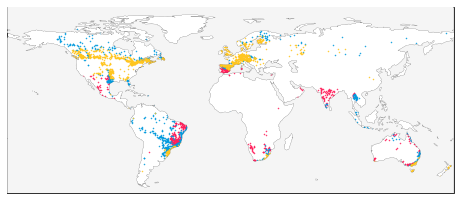

In [77]:
# p_mean
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)

fig, ax = plt.subplots(2,3, figsize=(12,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 1 # 'p_mean'
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
nm = slp.loc[neg].mean()
gr1 = slp[slp>pm].index
gr2 = slp[slp<pm].index

p = ice.index
gr1 = []
gr2 = []
gr3 = []
grr = []
for i in p:
    if (((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 14)):
        gr1.append(i)
    else:
        if (((ice.loc[i].iloc[99] - ice.loc[i].iloc[0])/(ice.columns[99] - ice.columns[0]) < -8)):
            grr.append(i)
        else:
            gr2.append(i)
gr4 = []
for i in grr:
    if (((ice.loc[i].iloc[35] - ice.loc[i].iloc[0])/(ice.columns[35] - ice.columns[0]) > 5)):
        gr4.append(i)
    else:
        gr3.append(i)
gr2 = np.concatenate([gr2,gr4])
# gr2 = slp[(slp<=pm) & (slp>0)].index
# gr3 = slp[(slp>=nm) & (slp<0)].index
# gr4 = slp[slp<nm].index

# gr1 = []
# for i in p:
#     if (((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 6)):
#         gr1.append(i)
    # else:
    #     gr3.append(i)

# p = np.concatenate([gr2,gr3])
# gr2=[]
# gr3=[]
# for i in p:
#     # if (((ice.loc[i].iloc[40] - ice.loc[i].iloc[0])/(ice.columns[40] - ice.columns[0]) > 0) & ((ice.loc[i].iloc[99] - ice.loc[i].iloc[70])/(ice.columns[99] - ice.columns[70]) < 0)): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]))
#     # if (((ice.loc[i].iloc[23] - ice.loc[i].iloc[0])/(ice.columns[23] - ice.columns[0]) > 20)): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]))
#     if (((ice.loc[i].iloc[23] - ice.loc[i].iloc[0])/(ice.columns[23] - ice.columns[0]) > 0) & ((ice.loc[i].iloc[99] - ice.loc[i].iloc[79])/(ice.columns[99] - ice.columns[79]) < 0)):
#         gr2.append(i)
#     else:
#         gr3.append(i)
# # gr1=[]
# # gr2=[]
# # for i in pos:
# #     if ((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 4): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0])): # 
# #         gr1.append(i)
# #     else:
# #         gr2.append(i)

# # gr3 = np.concatenate([gr3,gr4])
# gr3 = gr4

# plot pdps
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    # bins = np.linspace(np.quantile(df.loc[gr,features[k]],0.05),np.quantile(df.loc[gr,features[k]],0.95),20)
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(180,0)
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(180,0)
if (len(gr3)>0):
    gr = gr3
    j = 2
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(180,0)
# if (len(gr4)>0):
#     gr = gr4
#     j = 3
#     for i in gr:
#         ax[0,j].plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.05)
#     ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
#     ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
#     # ax[0,j].set_ylabel('Sr (mm)',size=13)
#     ax[0,j].set_ylim(0,600)
#     ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
#     ax[0,j].tick_params(axis='both', labelsize=13)
       
#     bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
#     ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
#     ax[1,j].invert_yaxis()
#     ax[1,j].xaxis.tick_top()
#     ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
#     ax[1,j].axes.get_xaxis().set_ticklabels([])
#     # ax[1,j].set_ylabel('n',size=13)
#     ax[1,j].tick_params(axis='both', labelsize=13)
#     ax[1,j].set_ylim(150,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
ax.plot(ddf.loc[gr3].lon, ddf.loc[gr3].lat,'o', markeredgecolor=c4, markerfacecolor=c4,markersize=0.5)
# ax.plot(ddf.loc[gr4].lon, ddf.loc[gr4].lat,'o', markeredgecolor='k', markerfacecolor='k',markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)





In [78]:
ice.iloc[:,0:10]

1.182214    1.220490    1.258766    1.297042    1.335318  \
ca_0002351  104.030865  103.516654  103.624803  104.740058  104.740058   
cz_0000019   58.695120   58.695120   58.695120   58.695120   58.695120   
br_0000469  308.831880  308.831880  308.831880  308.831880  308.831880   
bw_0000006  191.097624  193.150660  195.554410  196.612054  197.893664   
br_0003016   83.851712   83.851712   83.851712   83.851712   83.851712   
...                ...         ...         ...         ...         ...   
in_0000255  312.085635  312.085635  312.085635  312.085635  312.085635   
es_0000031  133.874295  133.874295  133.874295  133.874295  133.874295   
us_0006039  107.331499  107.331499  107.331499  107.331499  107.052722   
in_0000089  333.541621  333.541621  333.541621  333.541621  333.541621   
es_0000295  139.366904  139.366904  139.366904  139.366904  139.366904   

              1.373594    1.411869    1.450145    1.488421    1.526697  ...  \
ca_0002351  104.034028  105.000426  102.671662  102.515451  100.341633  ...   
cz_0000019   58.695120   57.290871   57.290871   57.290871   56.644476  ...   
br_0000469  308.831880  308.831880  308.831880  308.831880  308.831880  ...   
bw_0000006  198.455370  205.021435  207.205423  209.977400  209.673136  ...   
br_0003016   83.851712   83.851712   83.851712   83.851712   83.851712  ...   
...                ...         ...         ...         ...         ...  ...   
in_0000255  312.085635  314.078118  314.078118  314.078118  314.078118  ...   
es_0000031  133.874295  133.874295  133.874295  133.874295  133.874295  ...   
us_0006039  107.222362  106.626474  106.548629  106.949404  106.949404  ...   
in_0000089  333.541621  333.541621  333.541621  333.541621  333.541621  ...   
es_0000295  139.366904  139.366904  139.366904  139.366904  139.366904  ...   

              2.139111    2.177387    2.215662    2.253938    2.292214  \
ca_0002351   92.578728   92.578728   92.578728   92.578728   92.578728   
cz_0000019   56.114977   54.000169   53.609881   51.739678   50.711420   
br_0000469  309.904163  309.904163  309.904163  313.650996  315.509098   
bw_0000006  215.905899  217.129589  217.266461  217.266461  218.482362   
br_0003016   85.208853   85.641091   85.641091   84.483985   83.976433   
...                ...         ...         ...         ...         ...   
in_0000255  361.234650  362.479494  363.605371  370.017281  385.259944   
es_0000031  136.567351  134.995873  134.118516  132.803455  132.199590   
us_0006039  108.012632  108.182702  108.812207  107.615398  106.347352   
in_0000089  381.238663  382.483506  384.482180  395.763508  412.961320   
es_0000295  140.190961  139.081805  138.834762  137.771134  137.905119   

              2.330490    2.368766    2.407042    2.445318    2.483594  
ca_0002351   91.534353   91.534353   90.169452   90.169452   90.169452  
cz_0000019   49.765159   48.321271   47.604078   46.250120   44.323111  
br_0000469  315.132137  316.450234  316.528892  316.528892  316.528892  
bw_0000006  217.921390  215.917744  215.917744  215.933843  214.946325  
br_0003016   82.262299   81.445488   80.600504   78.290160   76.125411  
...                ...         ...         ...         ...         ...  
in_0000255  387.677258  387.677258  389.874891  389.874891  390.329798  
es_0000031  129.770934  125.554164  124.471393  121.973996  118.994975  
us_0006039  103.113795   99.995325   97.741694   92.477274   89.078292  
in_0000089  414.136087  414.136087  417.013842  417.013842  417.468749  
es_0000295  136.182076  133.392601  131.917391  131.042646  130.056104  

[3194 rows x 35 columns]

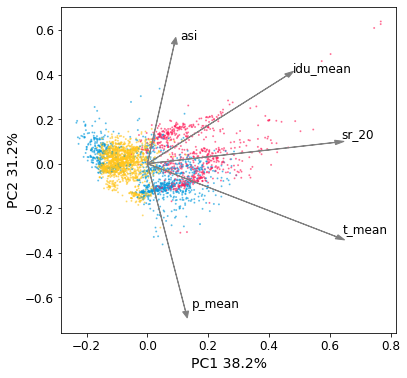

In [79]:
cmap = ListedColormap([c1,c2,c4])

features = ['t_mean','p_mean','idu_mean','asi']
# features = ['tdiff_mean','p_mean','idu_mean','asi']
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
ff = features
ff.append('sr_20')
df = df[ff]
df = df.loc[ice.index]
df.loc[gr1,'gr'] = 0
df.loc[gr2,'gr'] = 1
df.loc[gr3,'gr'] = 2
# df.loc[gr4,'gr'] = 3

xx = df[features]
xx = StandardScaler().fit_transform(xx) #standardize all values
xx = pd.DataFrame(xx,columns=ff)
pca = PCA(n_components=len(ff))
components = pca.fit_transform(xx)
loadings = pca.components_ #eigenvector, length represents variance var explains

# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
pca_df_scaled = pca_df.copy()
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

xs = loadings[0]
ys = loadings[1]
ld_df = pd.DataFrame(index=ff, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

fig=plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,c=df.gr,cmap=cmap)
for i, varnames in enumerate(ff):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[ff[i]]['xs'], # length of the arrow along x
        ld_df.loc[ff[i]]['ys'], # length of the arrow along y
        color='grey',
        head_width=0.02
        )
    ax.text(ld_df.loc[ff[i]]['xs']+0.02, ld_df.loc[ff[i]]['ys']+0.02, varnames,size=12)
# xticks = np.linspace(-0.5,0.7, num=5)
# yticks = np.linspace(-0.3,0.8, num=5)
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pca_p_mean_splitted.jpg',bbox_inches='tight',dpi=300)


In [ ]:
# extra scripts

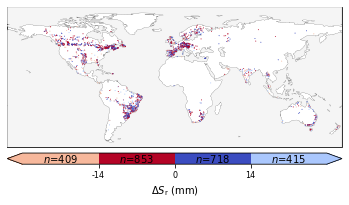

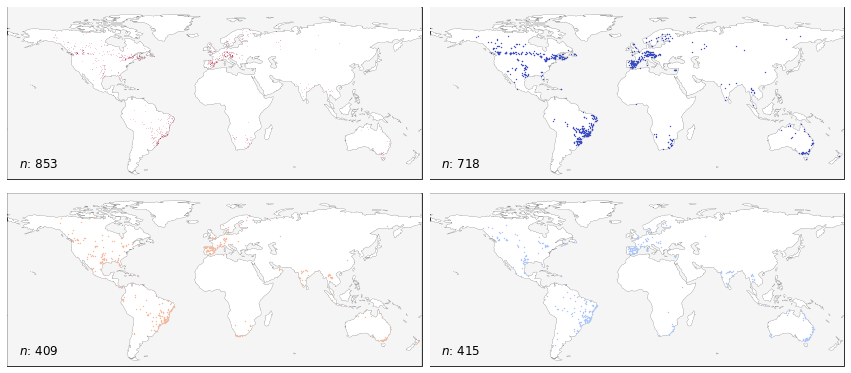

In [23]:
# maps
# cmap_vd2 = cm.get_cmap('RdBu', 21)
# cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
cmap=cmap_rdbu
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# TRAIN
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_train,lat_train,s=0.7,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{train_mae}','0',f'{train_mae}'],size=8)
for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
    cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')

# ax.set_title('train abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_5var_allcatch_maps.jpg',bbox_inches='tight',dpi=300)

# train maps
fig2 = plt.figure(figsize=(15,12))
plt.subplots_adjust(wspace=0.02,hspace=-0.6)
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 1
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=0.1,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)

ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 2
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=1.5,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)

ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 0
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=1.5,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)

ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 3
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=1.5,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_5var_allcatch_mapsd.jpg',bbox_inches='tight',dpi=300)



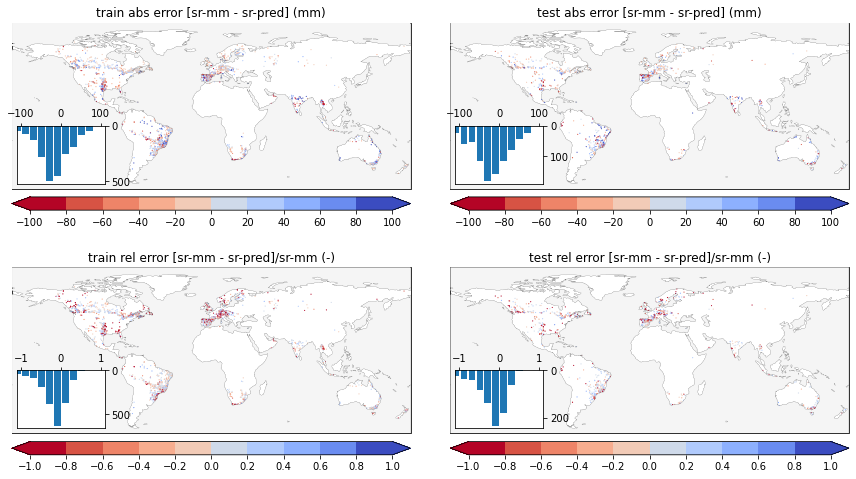

In [17]:
# maps
cmap_vd2 = cm.get_cmap('RdBu', 21)
cmap_rdbu = cm.get_cmap('coolwarm_r', 21)
# cmap_rdbu = cm.get_cmap('RdYlBu', 20)
# cmap_rdbu = cm.get_cmap('RdYlBu', 20)
# cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3),cmap_rdbu(4),cmap_rdbu(5),cmap_rdbu(6),cmap_rdbu(7),cmap_rdbu(8),
#                             (144/255,238/255,144/255),(144/255,238/255,144/255),
#                            cmap_rdbu(11),cmap_rdbu(12),cmap_rdbu(13),cmap_rdbu(14),cmap_rdbu(15),cmap_rdbu(16),cmap_rdbu(17),cmap_rdbu(18),cmap_rdbu(19)])

# cmap_rdbu = ListedColormap([cmap_rdbu(2),cmap_rdbu(3)])
bounds = np.linspace(-100,100,11)
bounds2 = np.linspace(-100,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

train_er = y_train - train_y_pred
test_er = y_test- test_y_pred
train_err = (y_train - train_y_pred)/y_train
test_err = (y_test- test_y_pred)/y_test
fig2 = plt.figure(figsize=(15,12))
plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_train,lat_train,s=1,c=train_er,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('train abs error [sr-mm - sr-pred] (mm)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(train_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()

ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_test,lat_test,s=1,c=test_er,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('test abs error [sr-mm - sr-pred] (mm)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(test_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()

bounds = np.linspace(-1,1,11)
bounds2 = np.linspace(-1,1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_train,lat_train,s=1,c=train_err,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('train rel error [sr-mm - sr-pred]/sr-mm (-)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(train_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()

ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_test,lat_test,s=1,c=test_err,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('test rel error [sr-mm - sr-pred]/sr-mm (-)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(test_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_5var_allcatch_maps.jpg',bbox_inches='tight',dpi=300)


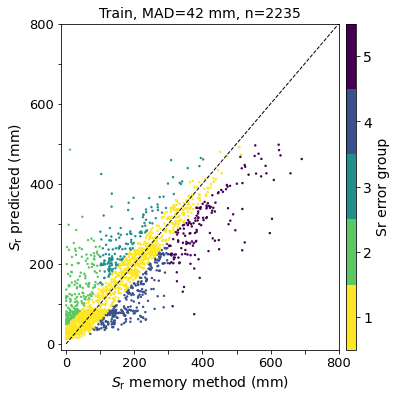

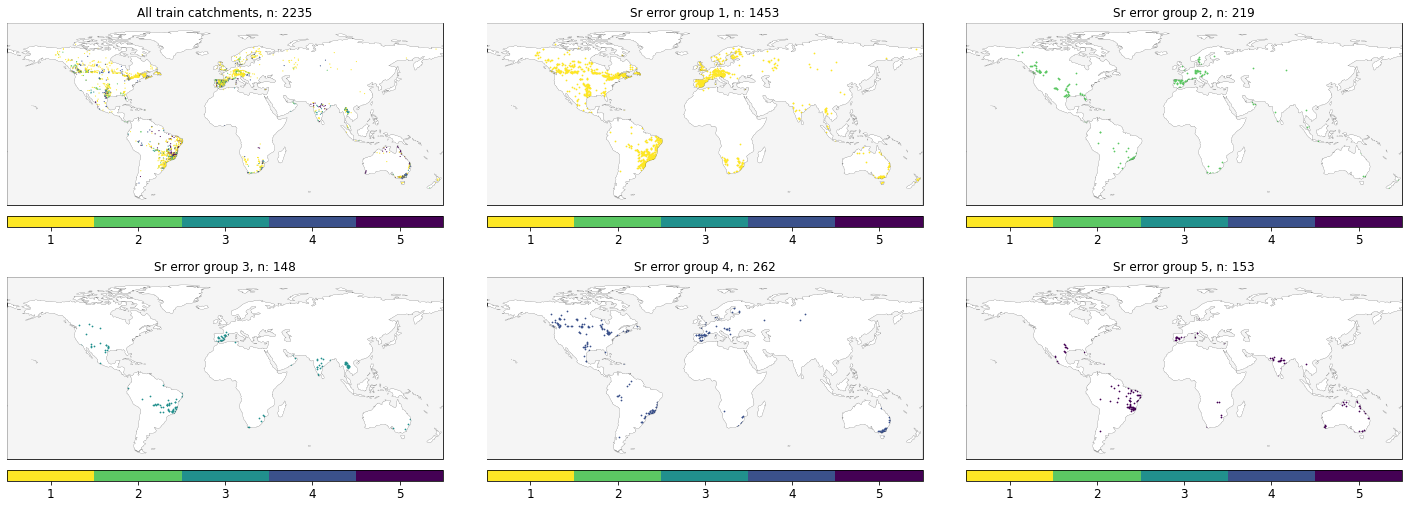

In [10]:
# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix1 = df_train[(df_train['Sr_p-Sr_m']<train_mae) | (df_train['Sr_p-Sr_m']>-train_mae)].index
ix2 = df_train[(df_train['Sr_p-Sr_m']>train_mae) & (df_train['Sr_m']<100)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>train_mae) & (df_train['Sr_m']>100)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae) & (df_train['Sr_m']<300)].index
ix5 = df_train[(df_train['Sr_p-Sr_m']<-train_mae) & (df_train['Sr_m']>300)].index

df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3
df_train.loc[ix5,'group'] = 4

# c2=(230/255,159/255,0/255)
# c3=(86/255,180/255,233/255)
# c4=(0/255,158/255,115/255)
# c5=(240/255,228/255,66/255)
# c6=(0/255,114/255,178/255)
# c7=(213/255,94/255,0/255)
# c8=(204/255,121/255,167/255)
# c = [c2,c4,c3,c5,c6]
# cml = ListedColormap(c)

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
cmap = cm.get_cmap('viridis_r', 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_subplot(111)
s=ax.scatter(df_train.Sr_m,df_train.Sr_p,c=df_train.group,s=2,cmap=cmap,norm=norm)
ax.plot([0,800],[0,800],'k--',linewidth=1)
ax.set_title(f'Train, MAD={train_mae} mm, n={n_train}',size=14)
ax.set_xlim(-15,800)
ax.set_ylim(-15,800)
ax.set_yticks([0,100,200,300,400,500,600,700,800])
ax.set_xticks([0,100,200,300,400,500,600,700,800])
ax.set_yticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=14)
ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=14)
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='neither', pad=0.02,aspect=30,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels(['1','2','3','4','5'])
cbar.set_label(label='Sr error group', size=14)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_train_grouped.jpg',bbox_inches='tight',dpi=300)

# maps
fig2 = plt.figure(figsize=(25,25))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.77)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
s=ax.scatter(lon_train,lat_train,s=1,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'All train catchments, n: {len(df_train)}',size=12)

ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==0].lon,df_train[df_train.group==0].lat,s=2.5,color=cmap(0),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 1, n: {len(df_train[df_train.group==0])}',size=12)

ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==1].lon,df_train[df_train.group==1].lat,s=2.5,color=cmap(1),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 2, n: {len(df_train[df_train.group==1])}',size=12)

ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==2].lon,df_train[df_train.group==2].lat,s=2.5,color=cmap(2),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 3, n: {len(df_train[df_train.group==2])}',size=12)

ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==3].lon,df_train[df_train.group==3].lat,s=2.5,color=cmap(3),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax,orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 4, n: {len(df_train[df_train.group==3])}',size=12)

ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==4].lon,df_train[df_train.group==4].lat,s=2.5,color=cmap(4),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 5, n: {len(df_train[df_train.group==4])}',size=12)

fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/maps_train_grouped.jpg',bbox_inches='tight',dpi=300)



In [47]:
# select catchments from test data to zoom in
# cid0 = 'za_0000220'
# cid1 = 'us_0005588'
# cid2 = 'ca_0004008'
# cid3 = 'es_0001098'
# cid4 = '410057'
# cid5 = 'br_0000292'

# without resampled points added to test
# cid0='br_0002638'
# cid1='es_0000236'
# cid2='ca_0005958'
# cid3='br_0001272'
# cid4='us_0006149'
# cid5='G8210010'

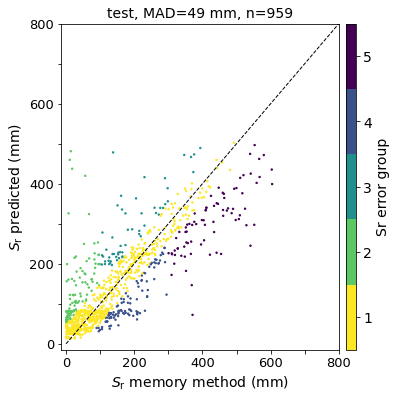

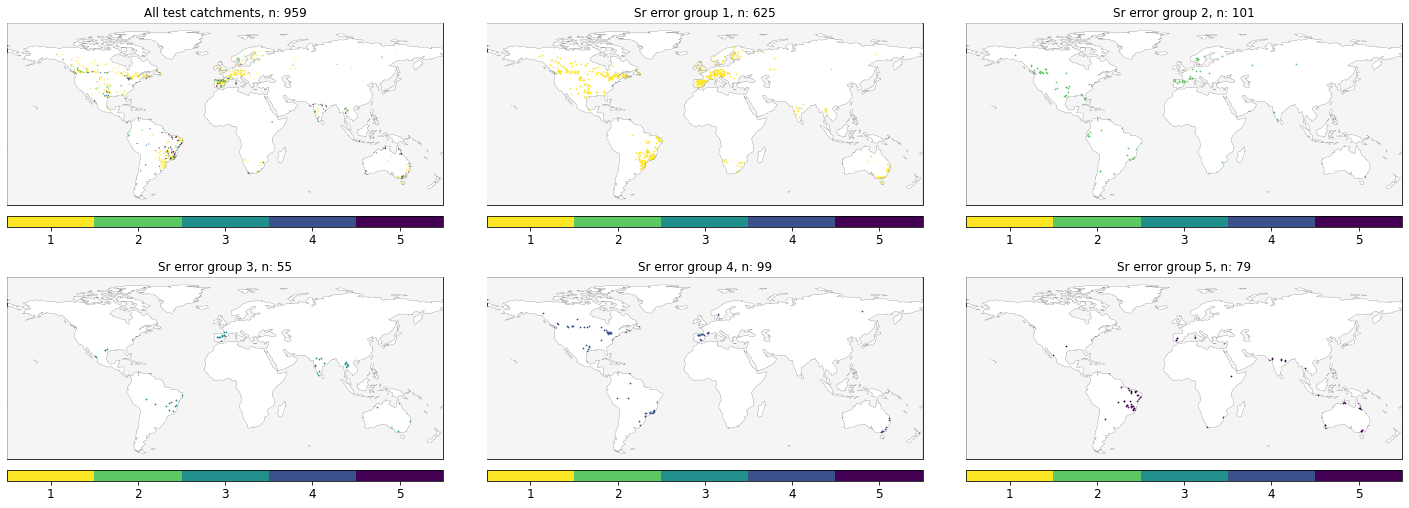

In [48]:
# color catchments in scatter plot based on error and use same colors on a map
df_test['group'] = np.nan
ix1 = df_test[(df_test['Sr_p-Sr_m']<test_mae) | (df_test['Sr_p-Sr_m']>-test_mae)].index
ix2 = df_test[(df_test['Sr_p-Sr_m']>test_mae) & (df_test['Sr_m']<100)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>test_mae) & (df_test['Sr_m']>100)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae) & (df_test['Sr_m']<300)].index
ix5 = df_test[(df_test['Sr_p-Sr_m']<-test_mae) & (df_test['Sr_m']>300)].index

df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3
df_test.loc[ix5,'group'] = 4

# c2=(230/255,159/255,0/255)
# c3=(86/255,180/255,233/255)
# c4=(0/255,158/255,115/255)
# c5=(240/255,228/255,66/255)
# c6=(0/255,114/255,178/255)
# c7=(213/255,94/255,0/255)
# c8=(204/255,121/255,167/255)
# c = [c2,c4,c3,c5,c6]
# cml = ListedColormap(c)

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
cmap = cm.get_cmap('viridis_r', 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_subplot(111)
s=ax.scatter(df_test.Sr_m,df_test.Sr_p,c=df_test.group,s=2,cmap=cmap,norm=norm)
ax.plot([0,800],[0,800],'k--',linewidth=1)
ax.set_title(f'test, MAD={test_mae} mm, n={n_test}',size=14)
ax.set_xlim(-15,800)
ax.set_ylim(-15,800)
ax.set_yticks([0,100,200,300,400,500,600,700,800])
ax.set_xticks([0,100,200,300,400,500,600,700,800])
ax.set_yticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=14)
ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=14)
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='neither', pad=0.02,aspect=30,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels(['1','2','3','4','5'])
cbar.set_label(label='Sr error group', size=14)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_test_grouped.jpg',bbox_inches='tight',dpi=300)

# maps
fig2 = plt.figure(figsize=(25,25))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.77)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
s=ax.scatter(lon_test,lat_test,s=1,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'All test catchments, n: {len(df_test)}',size=12)

ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==0].lon,df_test[df_test.group==0].lat,s=2.5,color=cmap(0),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 1, n: {len(df_test[df_test.group==0])}',size=12)

ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==1].lon,df_test[df_test.group==1].lat,s=2.5,color=cmap(1),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 2, n: {len(df_test[df_test.group==1])}',size=12)

ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==2].lon,df_test[df_test.group==2].lat,s=2.5,color=cmap(2),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 3, n: {len(df_test[df_test.group==2])}',size=12)

ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==3].lon,df_test[df_test.group==3].lat,s=2.5,color=cmap(3),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax,orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 4, n: {len(df_test[df_test.group==3])}',size=12)

ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==4].lon,df_test[df_test.group==4].lat,s=2.5,color=cmap(4),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 5, n: {len(df_test[df_test.group==4])}',size=12)

fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/maps_test_grouped.jpg',bbox_inches='tight',dpi=300)


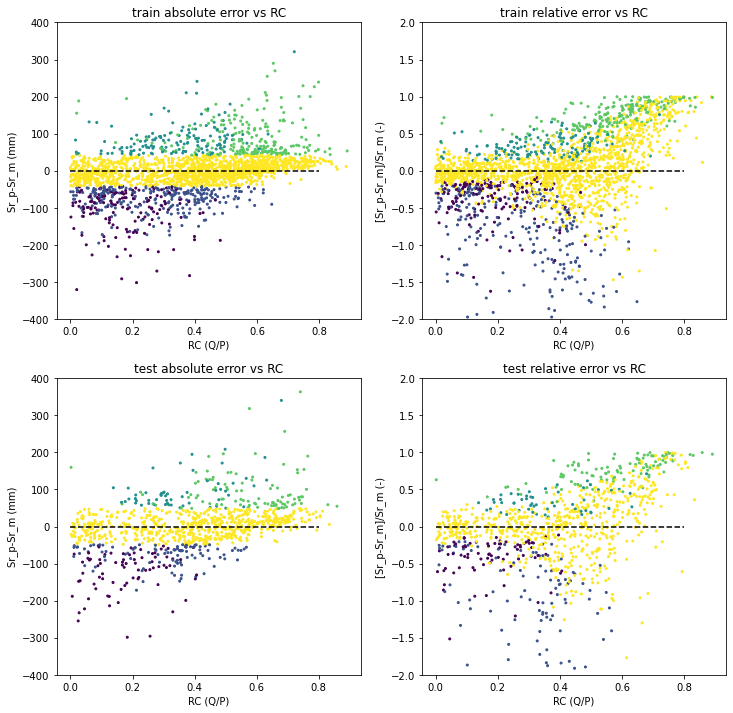

In [49]:
# plot error vs runoff coefficient
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)

df_test['rc'] = dff['q_mean']/dff['p_mean']
df_train['rc'] = dff['q_mean']/dff['p_mean']

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
cmap = cm.get_cmap('viridis_r', 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.scatter(df_train['rc'],df_train['Sr_p-Sr_m'],c=df_train['group'],s=4,cmap=cmap,norm=norm)
ax.plot([0,0.8],[0,0],'k--')
ax.set_ylim(-400,400)
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('Sr_p-Sr_m (mm)')
ax.set_title('train absolute error vs RC')

ax = fig.add_subplot(222)
ax.scatter(df_train['rc'],df_train['(Sr_p-Sr_m)/Sr_m'],c=df_train['group'],s=4,cmap=cmap,norm=norm)
ax.plot([0,0.8],[0,0],'k--')
ax.set_ylim(-2,2)
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('[Sr_p-Sr_m]/Sr_m (-)')
ax.set_title('train relative error vs RC')

ax = fig.add_subplot(223)
ax.scatter(df_test['rc'],df_test['Sr_p-Sr_m'],c=df_test['group'],s=4,cmap=cmap,norm=norm)
ax.set_ylim(-400,400)
ax.plot([0,0.8],[0,0],'k--')
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('Sr_p-Sr_m (mm)')
ax.set_title('test absolute error vs RC')

ax = fig.add_subplot(224)
ax.scatter(df_test['rc'],df_test['(Sr_p-Sr_m)/Sr_m'],c=df_test['group'],s=4,cmap=cmap,norm=norm)
ax.plot([0,0.8],[0,0],'k--')
ax.set_ylim(-2,2)
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('[Sr_p-Sr_m]/Sr_m (-)')
ax.set_title('test relative error vs RC')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/error_groups_rc.jpg',bbox_inches='tight',dpi=300)

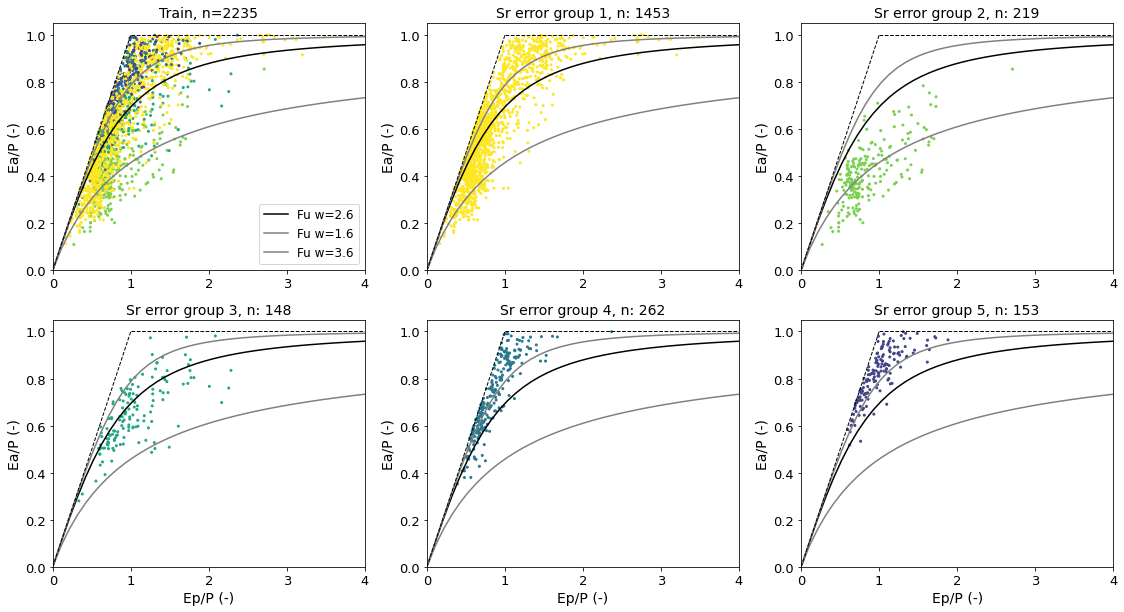

In [50]:
# plot in budyko
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)

df_train['bud_x'] = dff['ep_mean']/dff['p_mean']
df_train['bud_y'] = (dff['p_mean']-dff['q_mean'])/dff['p_mean']

ai = np.linspace(0.01,5,50)
budy_s = 1-np.exp(-ai)
budy_o = ai*np.tanh(1/ai)
budy_b = np.sqrt(ai*(np.tanh(1/ai)*(1-np.exp(-ai))))
budy_t = 1/(np.sqrt(0.9+((1/ai)**2)))
w=2.6
budy_f = 1 + ai - (1 + ai**w)**(1/w)
w = 1.6
budy_f1 = 1 + ai - (1 + ai**w)**(1/w)
w=3.6
budy_f2 = 1 + ai - (1 + ai**w)**(1/w)

# define the bins and normalize
bounds = np.linspace(0, 6, 7)
cmap = cm.get_cmap('viridis_r', 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(19,10))
ax = fig.add_subplot(231)
ax.scatter(df_train['bud_x'],df_train['bud_y'],c=df_train['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'Train, n={n_train}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.legend(fontsize=12)

ax = fig.add_subplot(232)
ax.scatter(df_train[df_train.group==0]['bud_x'],df_train[df_train.group==0]['bud_y'],c=df_train[df_train.group==0]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'Train, n={n_train}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 1, n: {len(df_train[df_train.group==0])}',size=14)

ax = fig.add_subplot(233)
ax.scatter(df_train[df_train.group==1]['bud_x'],df_train[df_train.group==1]['bud_y'],c=df_train[df_train.group==1]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 2, n: {len(df_train[df_train.group==1])}',size=14)

ax = fig.add_subplot(234)
ax.scatter(df_train[df_train.group==2]['bud_x'],df_train[df_train.group==2]['bud_y'],c=df_train[df_train.group==2]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 3, n: {len(df_train[df_train.group==2])}',size=14)

ax = fig.add_subplot(235)
ax.scatter(df_train[df_train.group==3]['bud_x'],df_train[df_train.group==3]['bud_y'],c=df_train[df_train.group==3]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 4, n: {len(df_train[df_train.group==3])}',size=14)

ax = fig.add_subplot(236)
ax.scatter(df_train[df_train.group==4]['bud_x'],df_train[df_train.group==4]['bud_y'],c=df_train[df_train.group==4]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 5, n: {len(df_train[df_train.group==4])}',size=14)

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/error_groups_budyko_train.jpg',bbox_inches='tight',dpi=300)


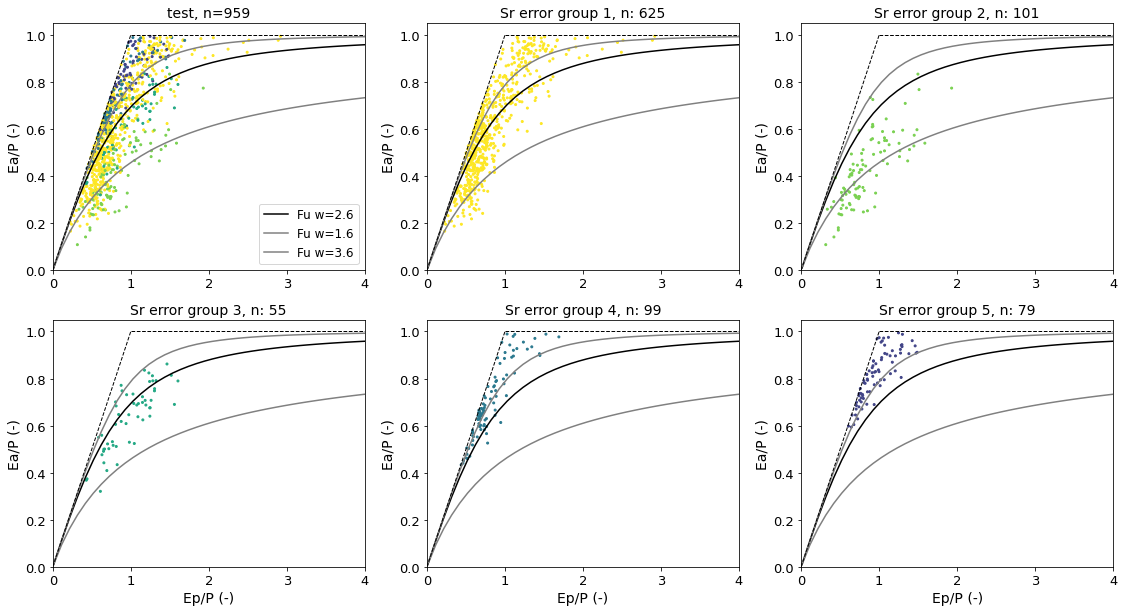

In [51]:
# plot in budyko
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)

df_test['bud_x'] = dff['ep_mean']/dff['p_mean']
df_test['bud_y'] = (dff['p_mean']-dff['q_mean'])/dff['p_mean']

# define the bins and normalize
bounds = np.linspace(0, 6, 7)
cmap = cm.get_cmap('viridis_r', 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(19,10))
ax = fig.add_subplot(231)
ax.scatter(df_test['bud_x'],df_test['bud_y'],c=df_test['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'test, n={n_test}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.legend(fontsize=12)

ax = fig.add_subplot(232)
ax.scatter(df_test[df_test.group==0]['bud_x'],df_test[df_test.group==0]['bud_y'],c=df_test[df_test.group==0]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'test, n={n_test}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 1, n: {len(df_test[df_test.group==0])}',size=14)

ax = fig.add_subplot(233)
ax.scatter(df_test[df_test.group==1]['bud_x'],df_test[df_test.group==1]['bud_y'],c=df_test[df_test.group==1]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 2, n: {len(df_test[df_test.group==1])}',size=14)

ax = fig.add_subplot(234)
ax.scatter(df_test[df_test.group==2]['bud_x'],df_test[df_test.group==2]['bud_y'],c=df_test[df_test.group==2]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 3, n: {len(df_test[df_test.group==2])}',size=14)

ax = fig.add_subplot(235)
ax.scatter(df_test[df_test.group==3]['bud_x'],df_test[df_test.group==3]['bud_y'],c=df_test[df_test.group==3]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 4, n: {len(df_test[df_test.group==3])}',size=14)

ax = fig.add_subplot(236)
ax.scatter(df_test[df_test.group==4]['bud_x'],df_test[df_test.group==4]['bud_y'],c=df_test[df_test.group==4]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 5, n: {len(df_test[df_test.group==4])}',size=14)

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/error_groups_budyko_test.jpg',bbox_inches='tight',dpi=300)

In [52]:
def plot_timeseries(cid,df_test):
    ms = pd.read_csv(f'{work_dir}/output/forcing_timeseries/mswep_p/mean_p_1981_2010.csv',index_col=0)
    eph = pd.read_csv(f'{work_dir}/output/forcing_timeseries/ep_hs_mean_catchments.csv',index_col=0)
    df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
    df['mswep_pmean'] = ms.mswep_pmean
    ts = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/{cid}_f0.9ia.csv',index_col=0)
    # ts2 = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/snow/sd/{cid}_nosnow.csv',index_col=0)
    ts.index = pd.to_datetime(ts.index)
    # ts2.index = pd.to_datetime(ts2.index)   
    ts = ts.groupby(pd.Grouper(freq="M")).mean()
    # ts2 = ts2.groupby(pd.Grouper(freq="M")).mean()
    
    sr = int(df_test.loc[cid].Sr_m)
    srp = int(df_test.loc[cid].Sr_p)
    epmhs = int(eph.loc[cid].ep_hs_mean*365)
    
    fig = plt.figure(figsize=(18,7))
    ax = fig.add_subplot(311)
    if ('sd2' in ts.columns):
        ax.plot(ts.index,ts.sd2,label='Sd (mm)')
    else:
        ax.plot(ts.index,ts.Sd,label='Sd (mm)')
    # ax.plot(ts2.index,ts2.Sd,label='Sd no snow (mm)')
    ax.set_title(f'{cid}, Srm: {sr} mm, Srp: {srp} mm, p_m-gswp={int(df.loc[cid].p_mean*365)} mm/y, p_m-mswep={int(df.loc[cid].mswep_pmean*365)} mm/y, q_m={int(df.loc[cid].q_mean*365)} mm/y, ep_m_gleam={int(df.loc[cid].ep_mean*365)} mm/y, ep_m_hs={epmhs}mm/y',size=14)
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=14)

    ax = fig.add_subplot(312)
    ax.plot(ts.index,ts.ep, label='Ep (mm/d)')
    ax.plot(ts.index,ts.Et, label='Et (mm/d)')
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=14)
    
    ax = fig.add_subplot(313)
    ax.plot(ts.index,ts.p, label='P (mm/d)')
    if ('ps' in ts.columns):
        ax.plot(ts.index,ts.ps, label='Ps (mm/d)')
        ax.plot(ts.index,ts.pl, label='Pl (mm/d)')
        ax.plot(ts.index,ts.pm, label='Pm (mm/d)')
    # ax.plot(ts.index,ts.Pe, label='Pe (mm/d)')
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=14)
    fig.savefig(f'{work_dir}/output/regression/figures/interpretation/test_timeseries_{cid}.jpg',bbox_inches='tight',dpi=300)
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.1)
    ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
    ax.set_global()
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.plot(df.loc[cid].lon,df.loc[cid].lat,'ro',zorder=101)
    sr = int(df.loc[cid].sr_20)
    srp = int(df_test.loc[cid].Sr_p)
    ax.set_title(f'Sr memory method: {sr} mm, Sr predicted: {srp} mm')

In [53]:
# plot_timeseries(cid0,df_test)
# plot_timeseries(cid1,df_test)
# plot_timeseries(cid2,df_test)
# plot_timeseries(cid3,df_test)
# plot_timeseries(cid4,df_test)
# plot_timeseries(cid5,df_test)

Text(0.5, 1.0, '')

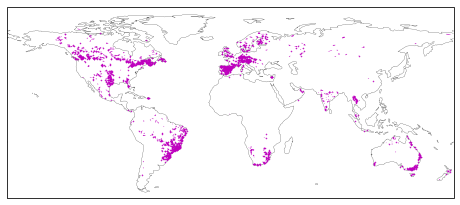

In [106]:
# plot shapes instead of points
sh = gpd.read_file(f'{work_dir}/output/geo_catchments.shp')
sh.index = sh.catch_id
sh = sh.loc[df_train.index]

area = pd.read_csv(f'{work_dir}/output/catchment_area.csv',index_col=0)
area = area.loc[df_train.index]
ixp = area[area.area<1500].index
ixs = area[area.area>1500].index
shp = sh.loc[ixs]
p = df_train.loc[ixp]

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
sh.plot(edgecolor=None,facecolor='m',linewidth=0.05,ax=ax)
ax.plot(p.lon,p.lat,'o', markeredgecolor='m', markerfacecolor='m',markersize=0.5)
ax.set_title(f'',size=20)

## COMPARISON LAN STOCKER

### STOCKER SR

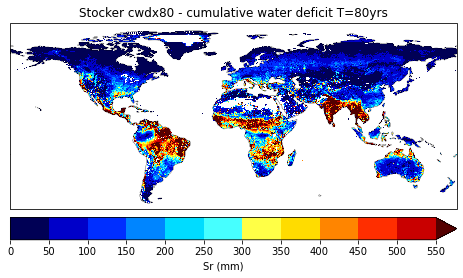

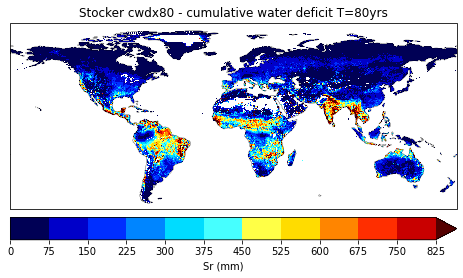

In [88]:
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80.nc')
s = s.cwdx80

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = s.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker cwdx80 - cumulative water deficit T=80yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_cwdx80.jpg',bbox_inches='tight',dpi=300)

lvls = np.arange(0,900,75) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = s.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker cwdx80 - cumulative water deficit T=80yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_cwdx80_v2.jpg',bbox_inches='tight',dpi=300)

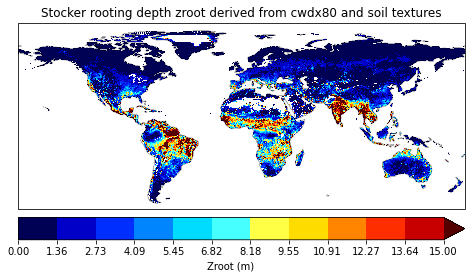

In [89]:
sd = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/zroot_cwd80.nc')
sd = sd.zroot_cwd80/1000 #convert to meters

lvls = np.linspace(0,15,12) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = sd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Zroot (m)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker rooting depth zroot derived from cwdx80 and soil textures')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_zroot_cwd80.jpg',bbox_inches='tight',dpi=300)

### LAN SR

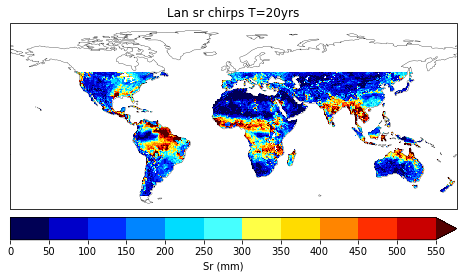

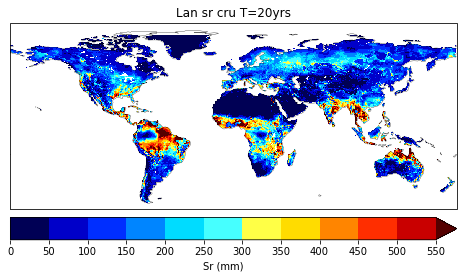

In [90]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_20yrs.nc')
l = l.sr_chirps_20yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps T=20yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_20yrs.jpg',bbox_inches='tight',dpi=300)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru T=20yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_20yrs.jpg',bbox_inches='tight',dpi=300)


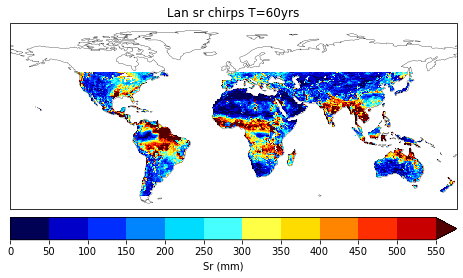

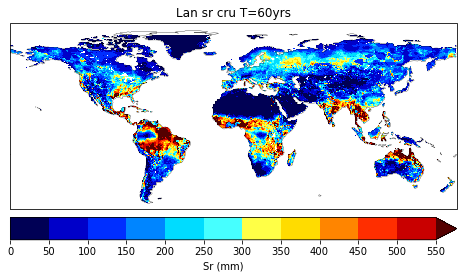

In [91]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_60yrs.nc')
l = l.sr_chirps_60yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps T=60yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_60yrs.jpg',bbox_inches='tight',dpi=300)


l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_60yrs.nc')
l = l.sr_cru_60yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru T=60yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_60yrs.jpg',bbox_inches='tight',dpi=300)


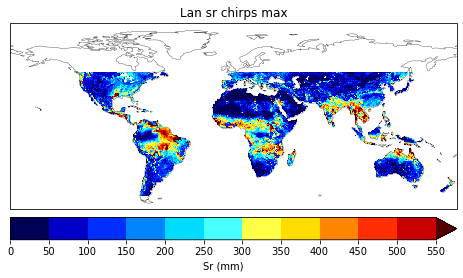

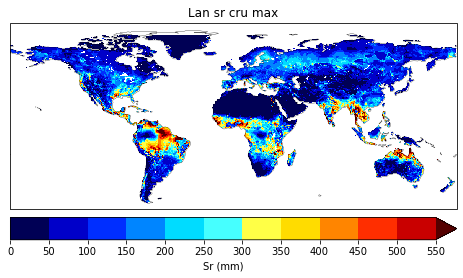

In [92]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_max.nc')
l = l.sr_chirps_max[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps max')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_max.jpg',bbox_inches='tight',dpi=300)


l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_max.nc')
l = l.sr_cru_max[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru max')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_max.jpg',bbox_inches='tight',dpi=300)


### SR COMPARISON

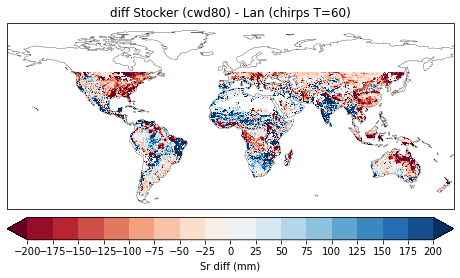

In [93]:
# diff lan-stocker
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_05grid.nc')
s = s.cwdx80

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_60yrs.nc')
l = l.sr_chirps_60yrs[0]

d = s-l

lvls = np.linspace(-200,200,17) # scale W-E paper
cmapb = mpl.cm.RdBu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = d.plot(ax=ax, cmap=cmapb, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr diff (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'diff Stocker (cwd80) - Lan (chirps T=60)')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_diff_lan_chirps_60yrs_stocker_cwd80.jpg',bbox_inches='tight',dpi=300)


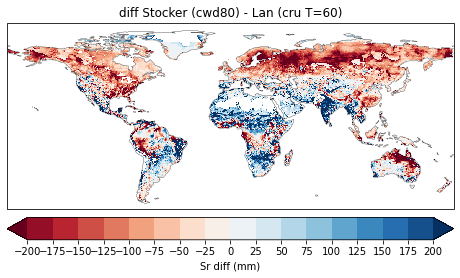

In [94]:
# diff lan-stocker
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_60yrs.nc')
l = l.sr_cru_60yrs[0]

d = s-l

lvls = np.linspace(-200,200,17) # scale W-E paper
cmapb = mpl.cm.RdBu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = d.plot(ax=ax, cmap=cmapb, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr diff (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'diff Stocker (cwd80) - Lan (cru T=60)')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_diff_lan_cru_60yrs_stocker_cwd80.jpg',bbox_inches='tight',dpi=300)


### COMPARE LAN STOCKER TO MY SR ESTIMATES

In [95]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments_maxmin_rzyear.csv',index_col=0)

# match sh and sr dfs
sh_sr = sh.loc[sr_df.index]
sh_sr['sr_20'] = sr_df['20']
sh_sr = sh_sr.drop(columns=['geometry'])
sh_sr = sh_sr.rename(columns={'centroid':'geometry'})

sr_df['lon'] = sh_sr.centroid.x
sr_df['lat'] = sh_sr.centroid.y

ls = pd.read_csv(f'{work_dir}/output/sr_calculation/stocker_lan_sr_df.csv',index_col=0)

a = sr_df.index.to_list()
b = ls.index.to_list()
dif = list(set(a) - set(b))
sr_df = sr_df.drop(index=dif)

ls = ls.loc[sr_df.index]

# lvls = np.linspace(0,600,13)
# fig = plt.figure(figsize=(8,6))
# # cm = plt.cm.get_cmap('jet')
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
# pl = sh_sr.plot(column='sr_20',ax=ax, markersize=0.8, cmap=cm,
#            k=10,vmin=0,vmax=600,
#            legend=True,
#            legend_kwds={'label': "Sr (mm)", 'orientation': "horizontal", 'pad':0.02,'ticks':lvls})
# ax.set_title(f'Sr T=20, #catchments:{len(sr_df)}',size=16)
# fig.savefig(f'{out_dir}/figures/sr_figures/sr_map_T20.jpg',bbox_inches='tight',dpi=300)

/tmp/ipykernel_403/3489674508.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_403/3489674508.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sr_df['lon'] = sh_sr.centroid.x
/tmp/ipykernel_403/3489674508.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sr_df['lat'] = sh_sr.centroid.y


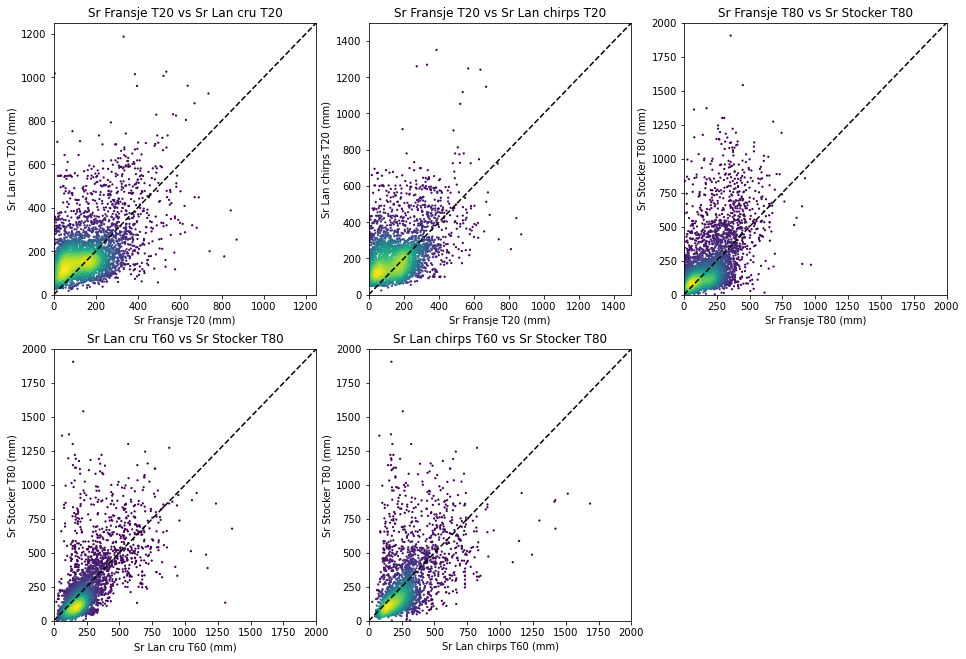

In [96]:
fig = plt.figure(figsize=(16,11))
ax = fig.add_subplot(231)
x = sr_df['20']
y = ls['lan_cru_20yrs']
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,1250)
ax.set_ylim(0,1250)
ax.set_xlabel('Sr Fransje T20 (mm)')
ax.set_ylabel('Sr Lan cru T20 (mm)')
ax.set_title('Sr Fransje T20 vs Sr Lan cru T20')

ax = fig.add_subplot(232)
x = sr_df['20']
y = ls['lan_chirps_20yrs']
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,1500)
ax.set_ylim(0,1500)
ax.set_xlabel('Sr Fransje T20 (mm)')
ax.set_ylabel('Sr Lan chirps T20 (mm)')
ax.set_title('Sr Fransje T20 vs Sr Lan chirps T20')

ax = fig.add_subplot(233)
x = sr_df['80']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Fransje T80 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Fransje T80 vs Sr Stocker T80')

ax = fig.add_subplot(234)
x = ls['lan_cru_60yrs']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Lan cru T60 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Lan cru T60 vs Sr Stocker T80')

ax = fig.add_subplot(235)
x = ls['lan_chirps_60yrs']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Lan chirps T60 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Lan chirps T60 vs Sr Stocker T80')
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_reference',bbox_inches='tight',dpi=300)


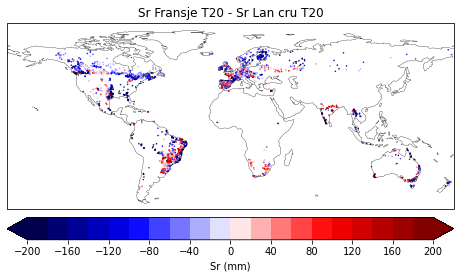

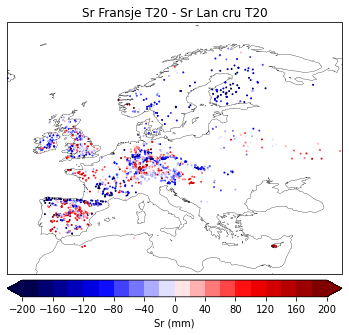

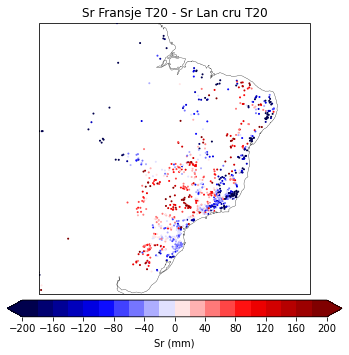

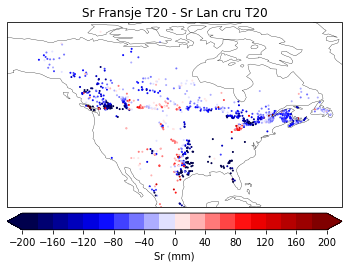

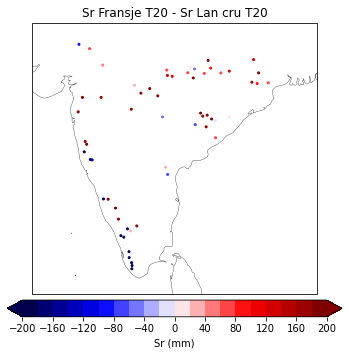

In [97]:
# Fransje vs Lan cru T20

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['20']-ls['lan_cru_20yrs']
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_india.jpg',bbox_inches='tight',dpi=300)


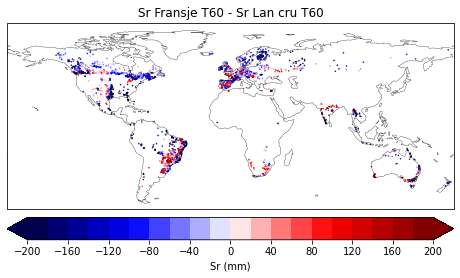

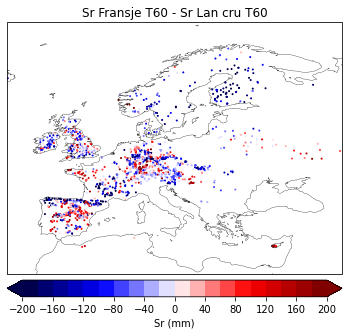

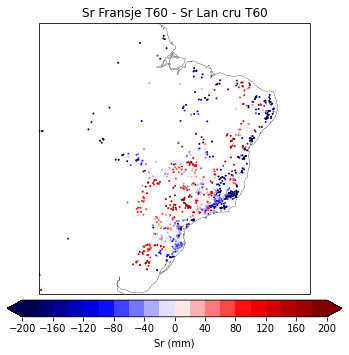

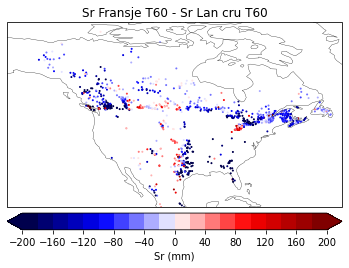

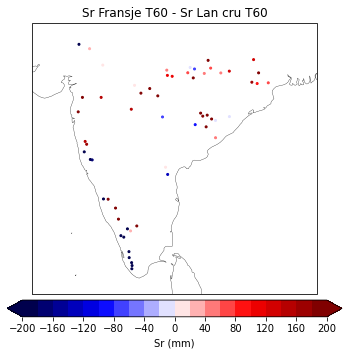

In [98]:
# Fransje vs Lan cru T60

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['60']-ls['lan_cru_60yrs']

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_india.jpg',bbox_inches='tight',dpi=300)

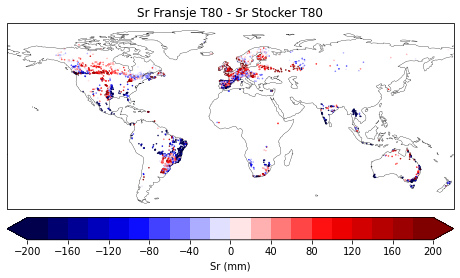

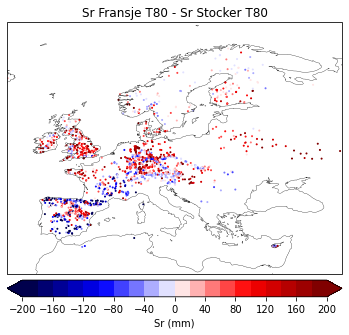

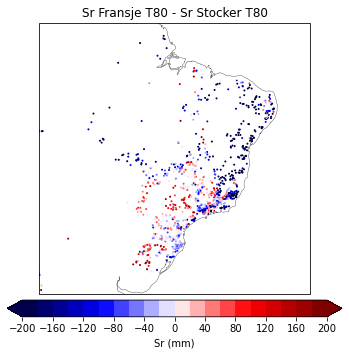

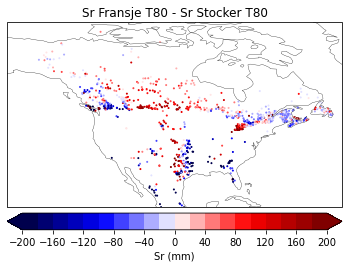

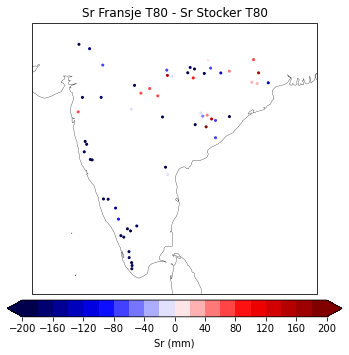

In [101]:
# Fransje vs Stocker T80

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['80']-ls['stocker_cwd80x_mm']

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_india.jpg',bbox_inches='tight',dpi=300)

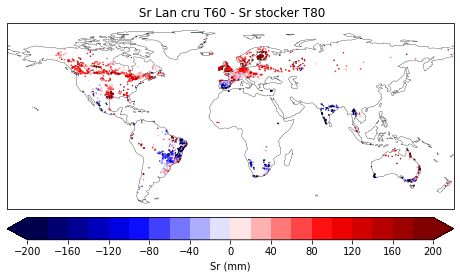

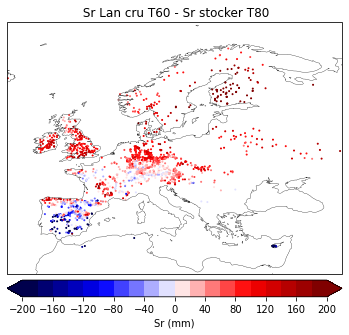

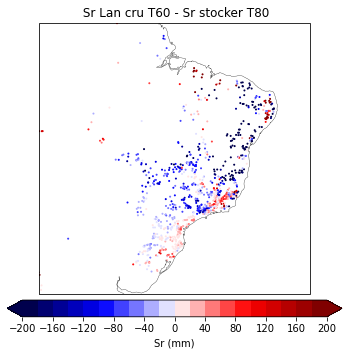

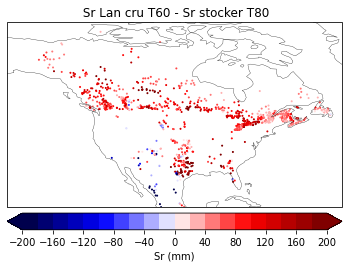

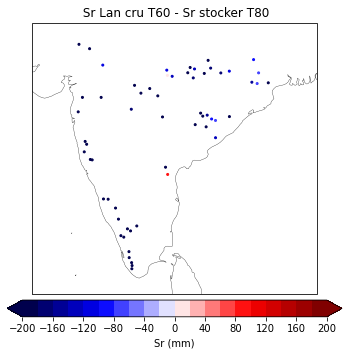

In [102]:
# Lan T60 vs Stocker T80

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = ls['lan_cru_60yrs'] - ls['stocker_cwd80x_mm']

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_india.jpg',bbox_inches='tight',dpi=300)